# Pulsating Variable Star Accelerometer Pipeline
Measuring Accelerations From Pulsating Variable Stars MAFPVS

Measuring Accelerations Using Pulsating Variable Stars MAUPVS

Measuring Accelerations with Pulsating Stars MAPS 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy.io import fits
from scipy.signal import argrelextrema
from scipy.optimize import minimize, curve_fit
from scipy.fft import rfft, rfftfreq, irfft
from scipy.stats import linregress
from numpy import polyfit
from astropy.modeling import models, fitting
import pickle
import pywt
import wget

In [4]:
#all the fits files for the same star
fits_filenames = [
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q1.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q2.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q3.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q4.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q5.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q6.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q7.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q8.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q9.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q10.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q11.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q12.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q13.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q14.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q15.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q16.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q17.fits',
                 ]

#load in all the data and build the dictionaries
data = {}
i = 0
for f in fits_filenames:
    
    hdul = fits.open(f)
    splits = [] #context, this may not be required
    
    #split the data up more
    
    #define the splitting for each data period
    len_hdul = len(hdul[1].data['time'])
    if (i != 0) and (f != fits_filenames[-1]): #skip the first and the last, they're already smaller
        n_splits = 8
        splits = [np.arange(j*len_hdul//n_splits, (j+1)*len_hdul//n_splits) for j in range(n_splits)]
    else:
        splits = [np.arange(0, len_hdul)]
    
    for split in splits: #there will only be 1 split if you don't need to split up that data
        
        # Read in the "BJDREF" which is the time offset of the time array.
        bjdrefi = hdul[1].header['BJDREFI']
        bjdreff = hdul[1].header['BJDREFF']

        # Read in the columns of data.
        times = hdul[1].data['time'][split]
        sap_fluxes = hdul[1].data['SAP_FLUX'][split]
        pdcsap_fluxes = hdul[1].data['PDCSAP_FLUX'][split]

        bjds = times + bjdrefi + bjdreff 

        sample_spacing = (bjds[-1] - bjds[0])/len(bjds)
        sample_rate = 1/sample_spacing

        data[i] = {
                   'bjds': bjds,
                   'sap_fluxes': sap_fluxes,
                   'pdcsap_fluxes': pdcsap_fluxes,
                   'sample_spacing': sample_spacing,
                   'sample_rate': sample_rate
                  }
        
        i += 1
    
print('data read in successfully')


data read in successfully


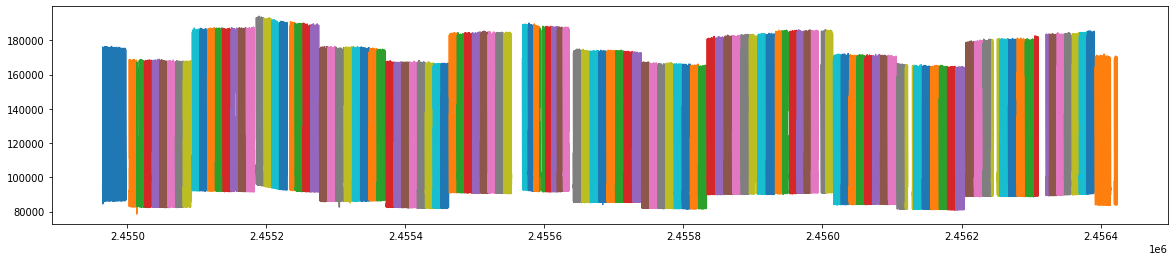

In [5]:
#make some plots of the data

#all the data
fig = plt.figure(figsize=(20, 4))
for key in data.keys():
    plt.plot(data[key]['bjds'], data[key]['pdcsap_fluxes'])
plt.show()

# #each time slice
# for key in data.keys():
#     fig = plt.figure(figsize=(20, 4))
#     plt.plot(data[key]['bjds'], data[key]['pdcsap_fluxes'])
#     plt.show()

scale of fft: 0.0008777403511161335  inverse BJDs


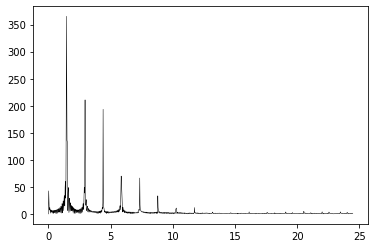

fund. freq.: 1.451237056845795 days^-1
period: 0.6890672997101241 days


In [6]:
#do a fft and find the fundamental frequency

pdcsap_fluxes = np.array([])
for i in range(100):
    pdcsap_fluxes = np.append(pdcsap_fluxes, data[i]['pdcsap_fluxes'])

#--------------------
#have to fix the fluxes first to actually get an fft
interp_pdcsap_fluxes = [(pdcsap_fluxes[i] if not(np.isnan(pdcsap_fluxes[i])) else (pdcsap_fluxes[i-1] + pdcsap_fluxes[i+1])/2 ) for i in range(len(pdcsap_fluxes))]

for j in range(100):
    interp_pdcsap_fluxes = [(interp_pdcsap_fluxes[i] if not(np.isnan(interp_pdcsap_fluxes[i])) else (interp_pdcsap_fluxes[i-j] + interp_pdcsap_fluxes[i+j])/2 ) for i in range(len(pdcsap_fluxes))]
    
i = 0
while i < len(interp_pdcsap_fluxes) and not(np.isnan(interp_pdcsap_fluxes[i])):
    i += 1
interp_pdcsap_fluxes = interp_pdcsap_fluxes[:i]
#-------------------

#compute the fft
tmp = interp_pdcsap_fluxes - np.mean(interp_pdcsap_fluxes)
power_series = rfft(tmp / np.max(tmp))
mag_power_series = np.abs(power_series)
power_series_bins = rfftfreq(len(interp_pdcsap_fluxes), sample_spacing)

delta_f = sample_rate / len(pdcsap_fluxes)
print('scale of fft:', delta_f, ' inverse BJDs')

plt.plot(power_series_bins, mag_power_series, c='k', lw=0.5)
plt.show()

#calculate the period
ffreq = power_series_bins[np.argmax(mag_power_series)]
period = 1/ffreq #0.68202 #BJDs, technically a period guess
print('fund. freq.:', ffreq, 'days^-1')
print('period:', period, 'days')

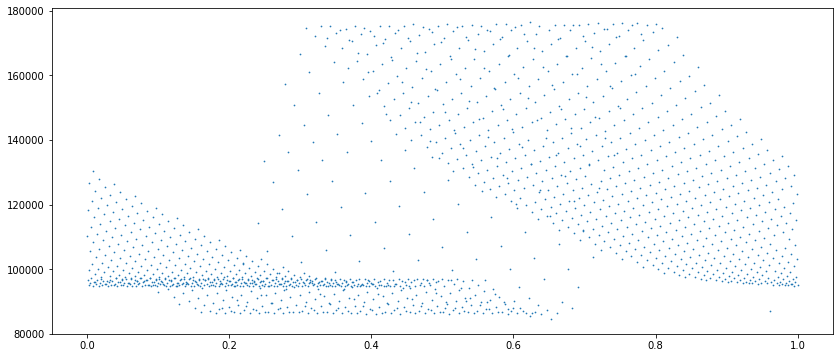

/tmp/ipykernel_18440/1547315382.py:4: RuntimeWarning: invalid value encountered in remainder
  folded_bjds = (data[key]['bjds'] % period)/period


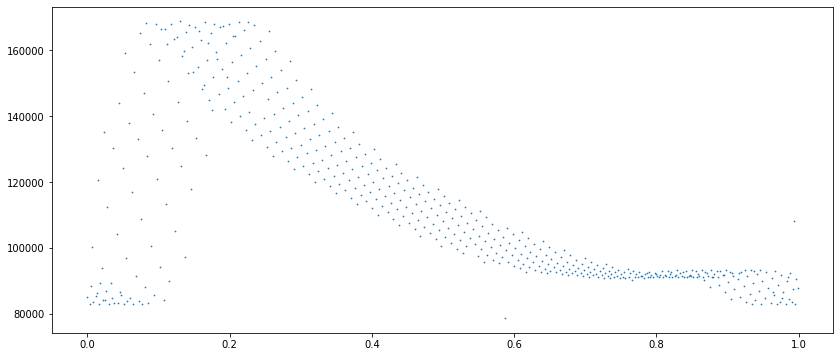

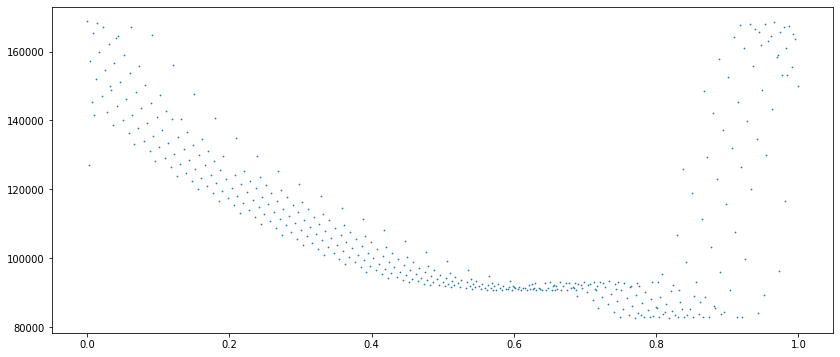

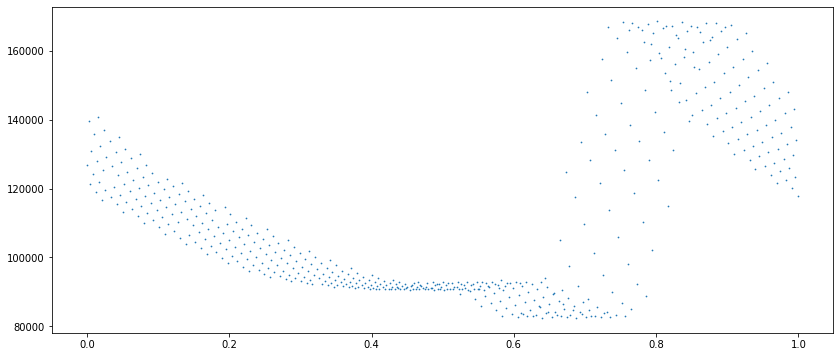

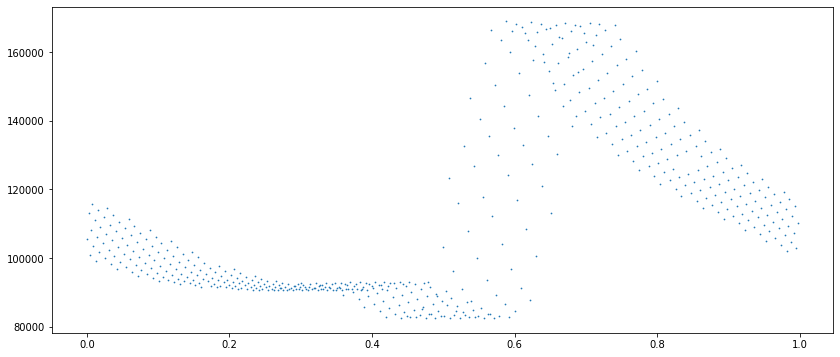

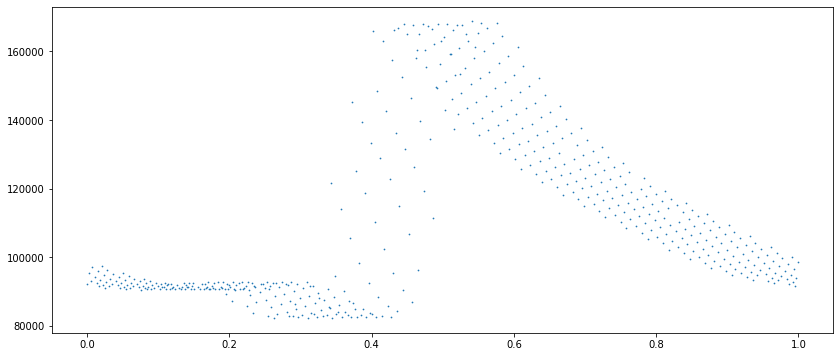

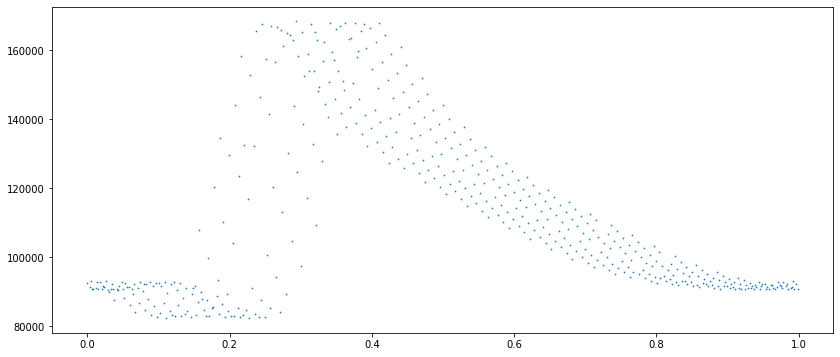

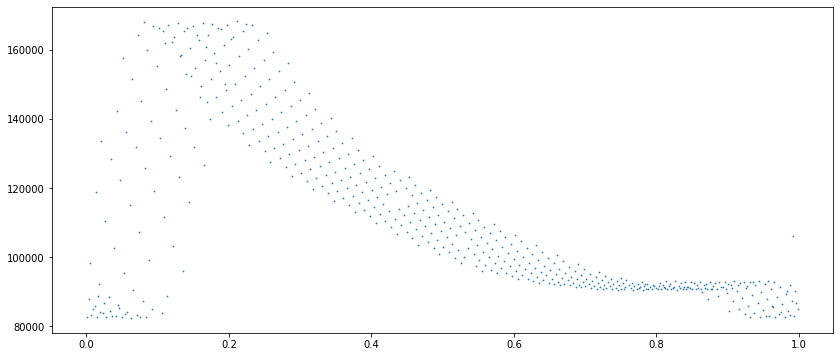

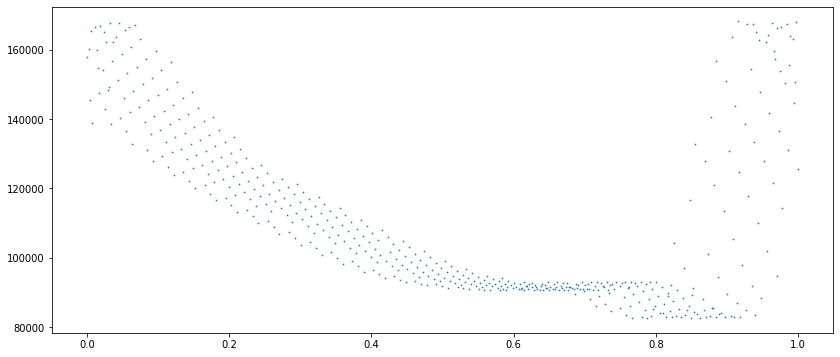

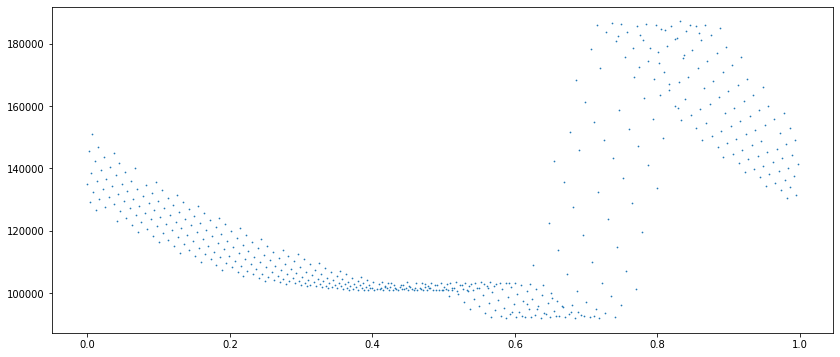

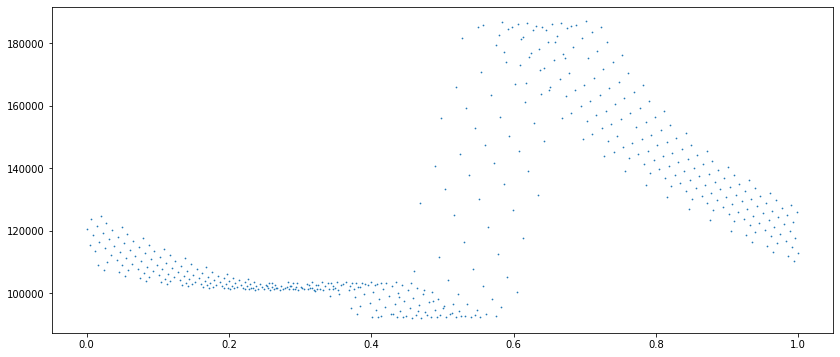

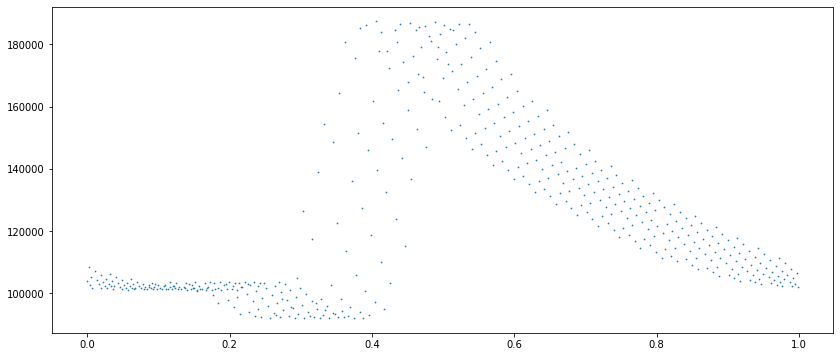

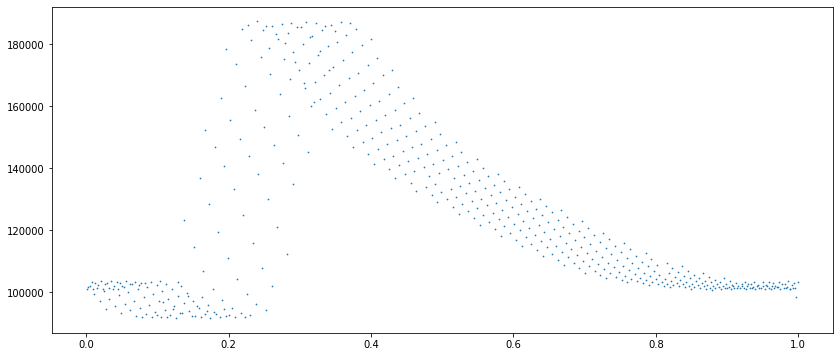

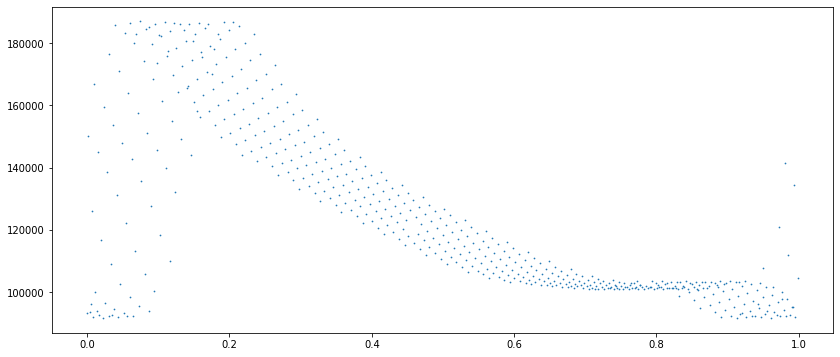

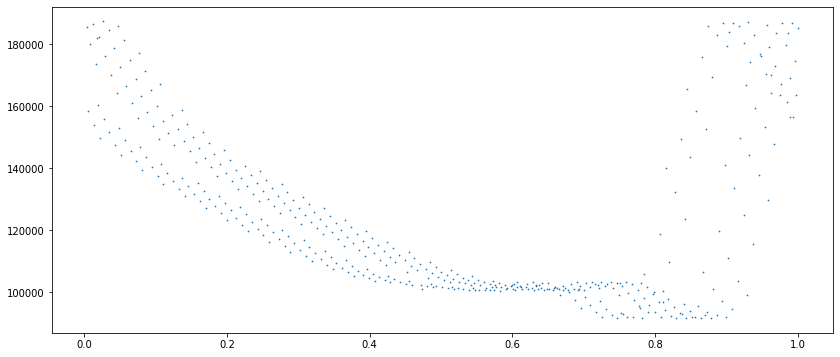

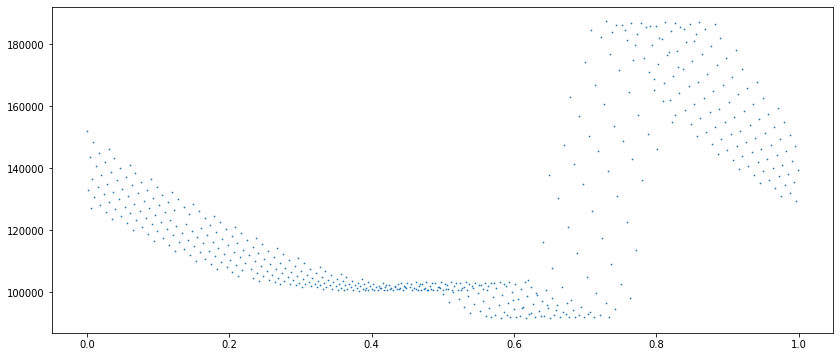

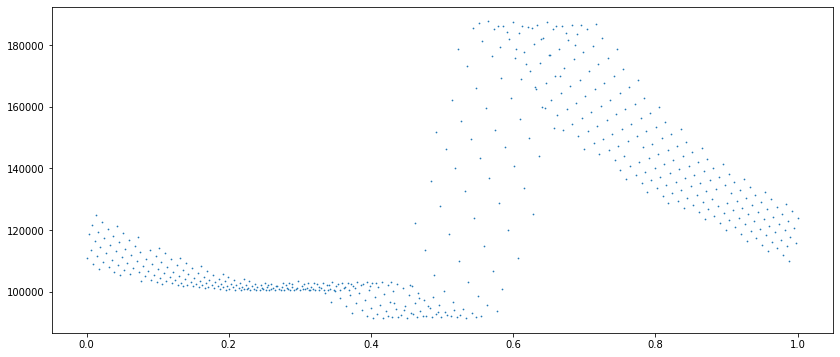

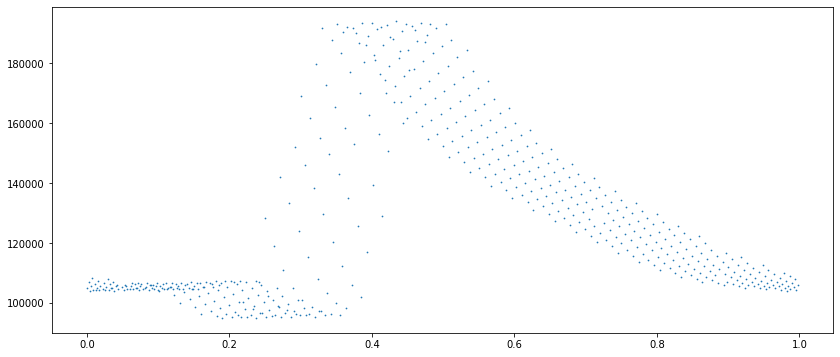

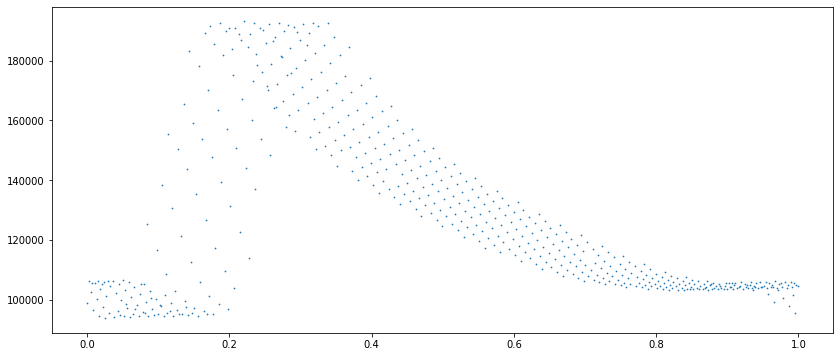

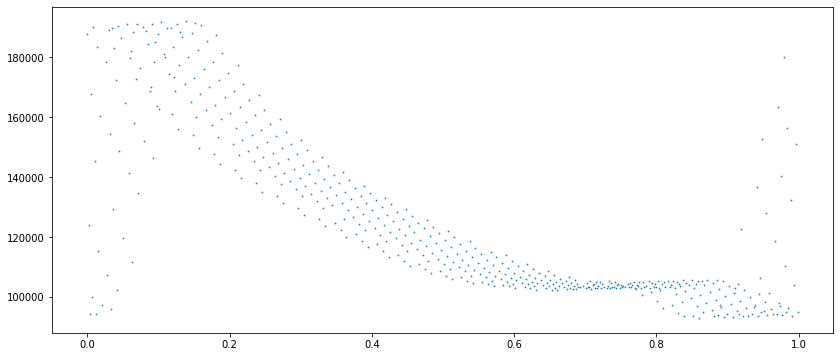

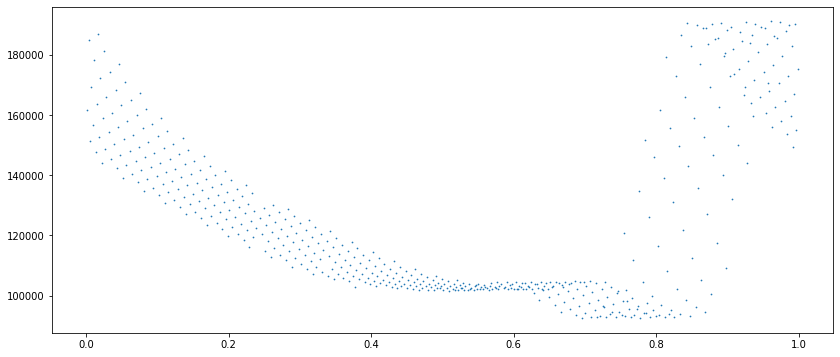

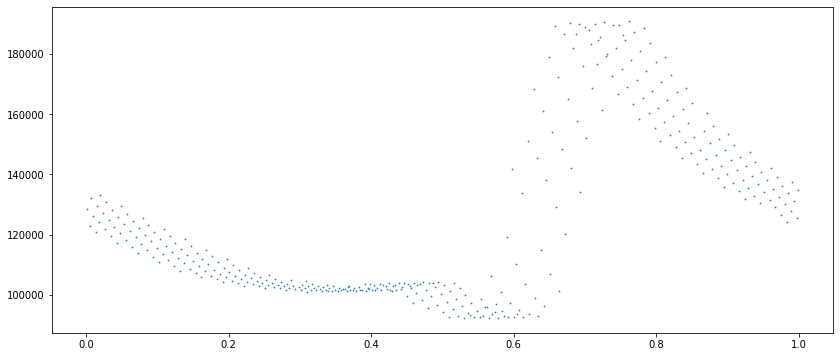

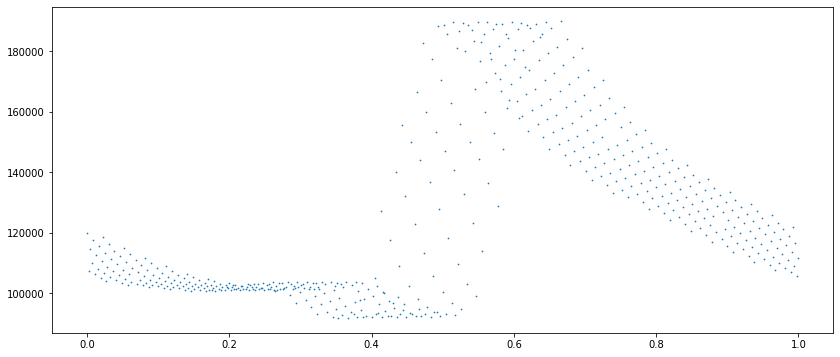

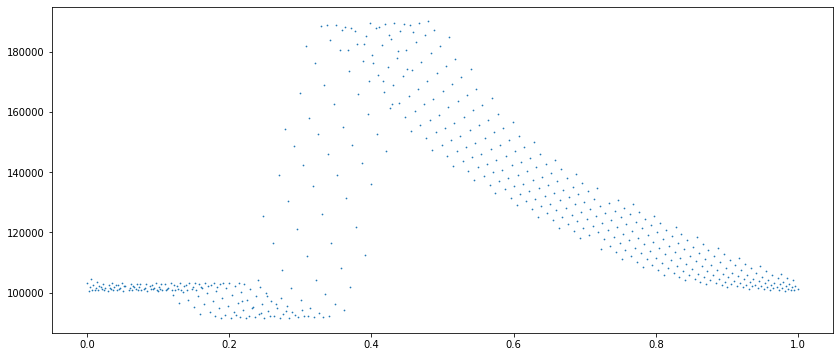

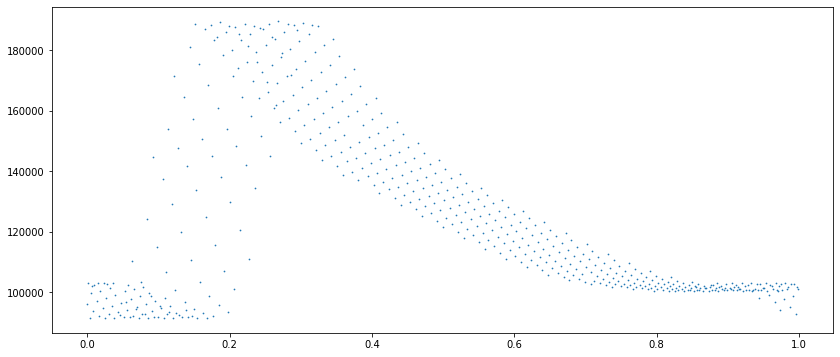

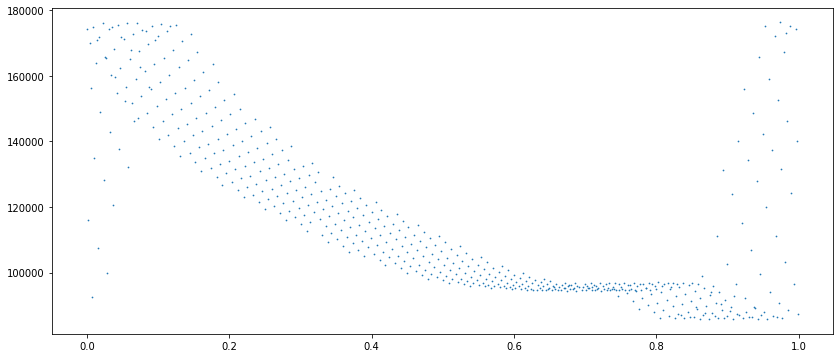

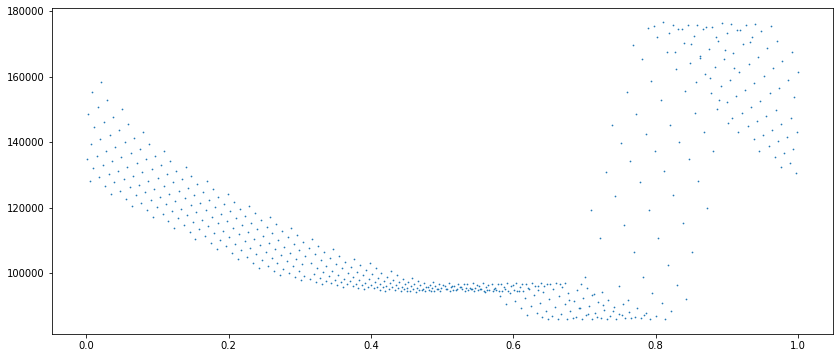

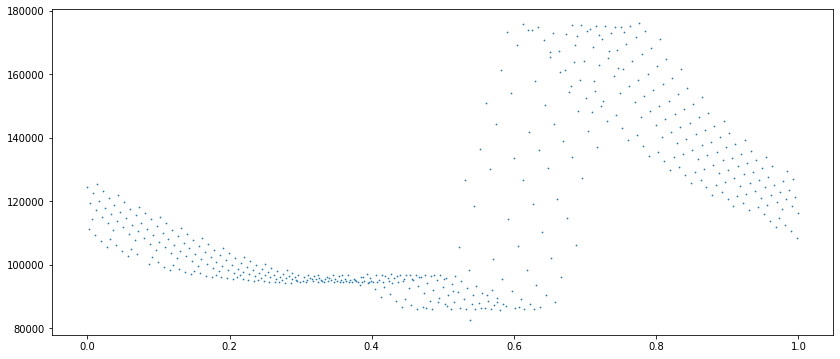

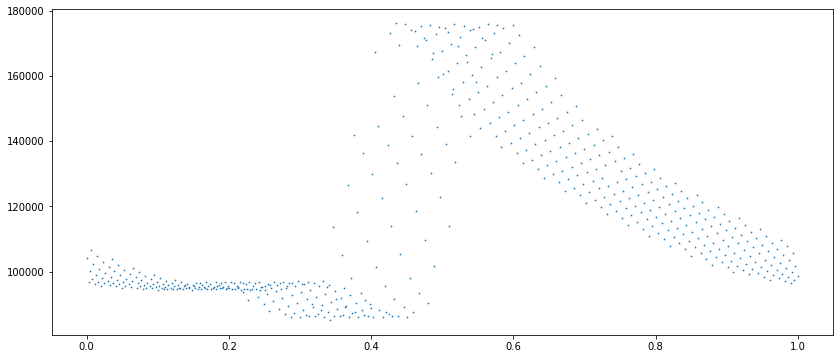

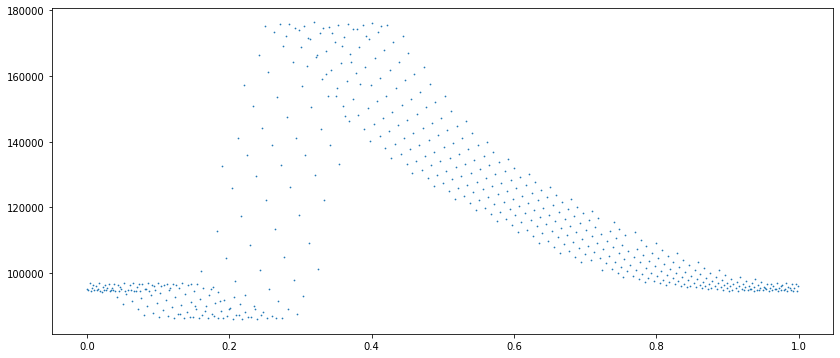

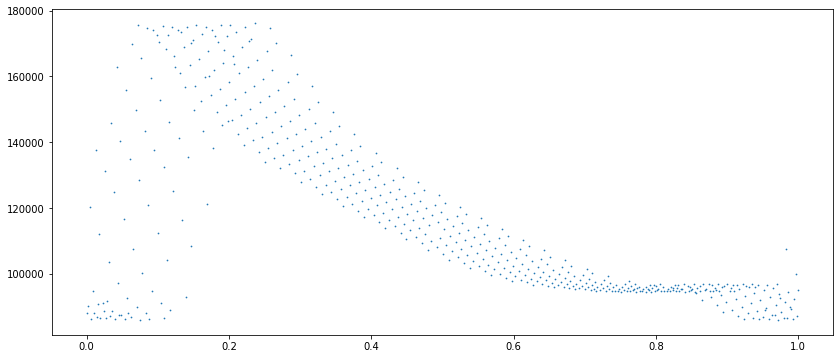

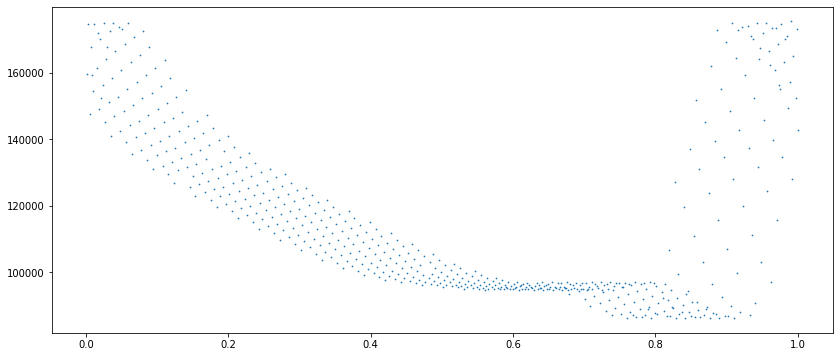

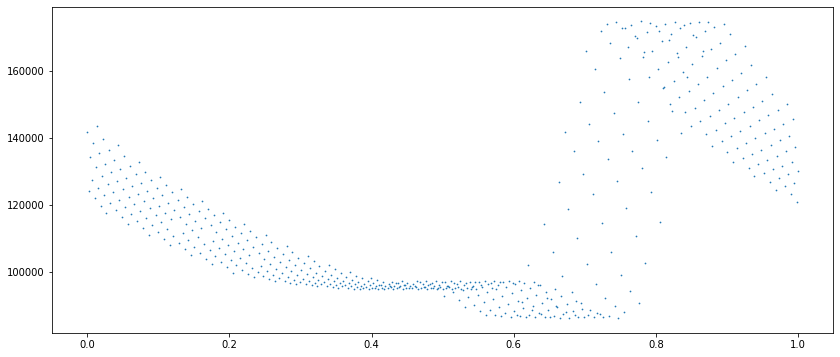

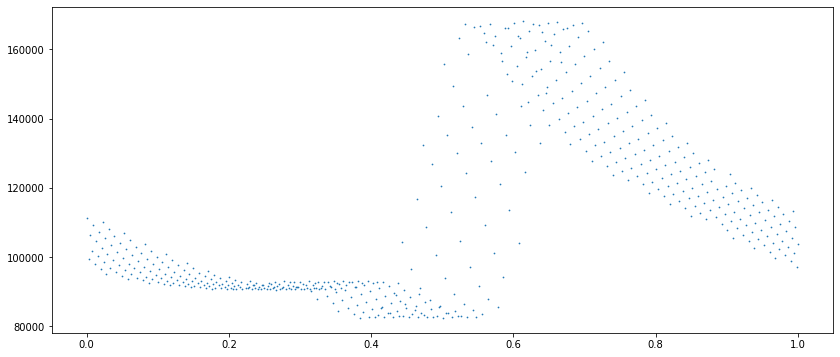

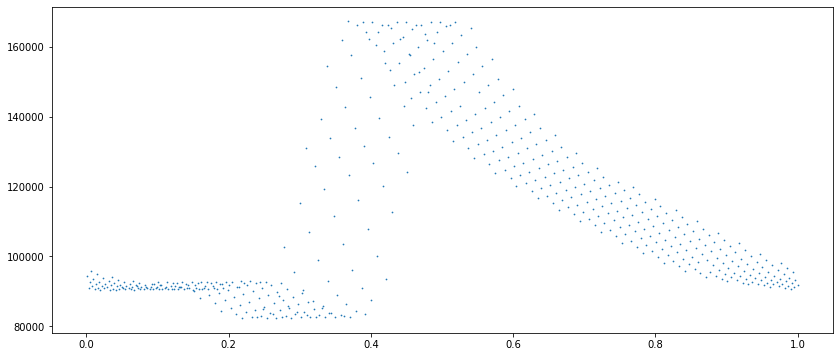

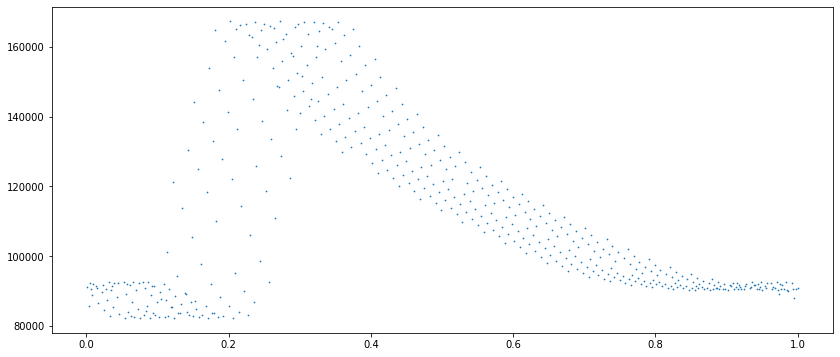

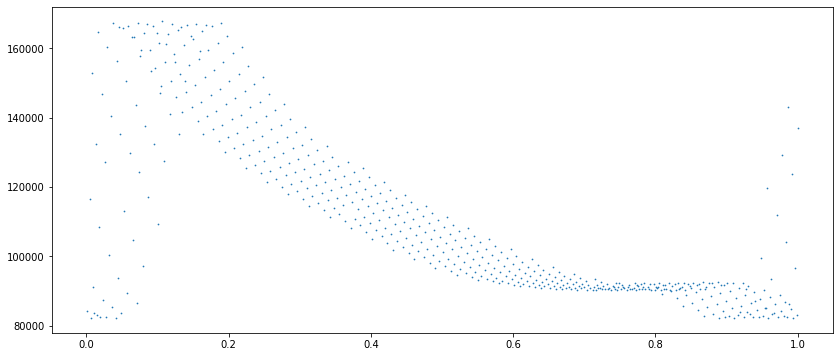

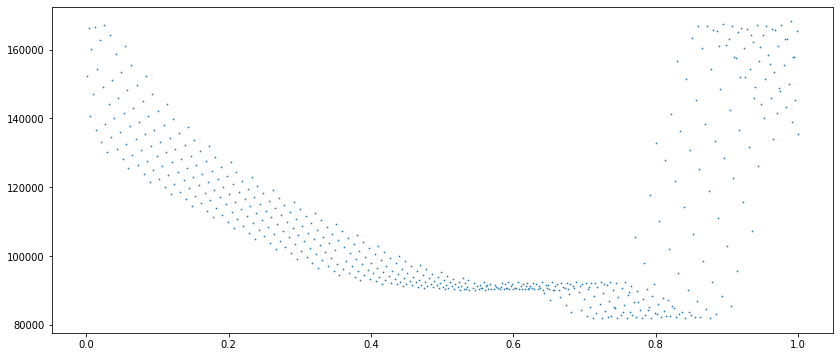

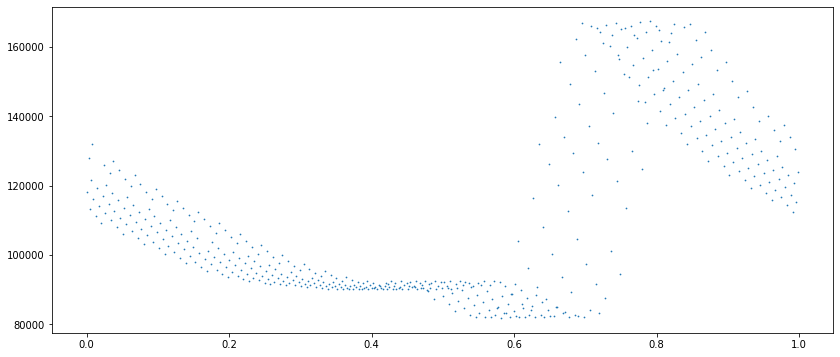

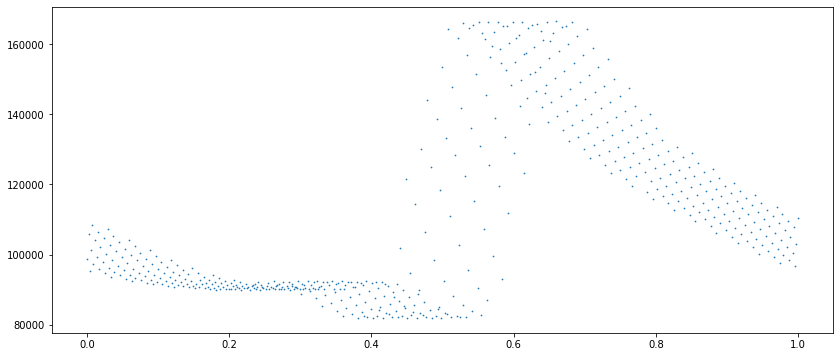

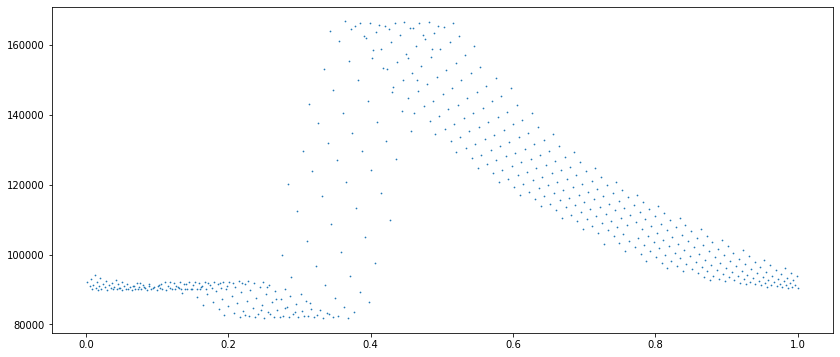

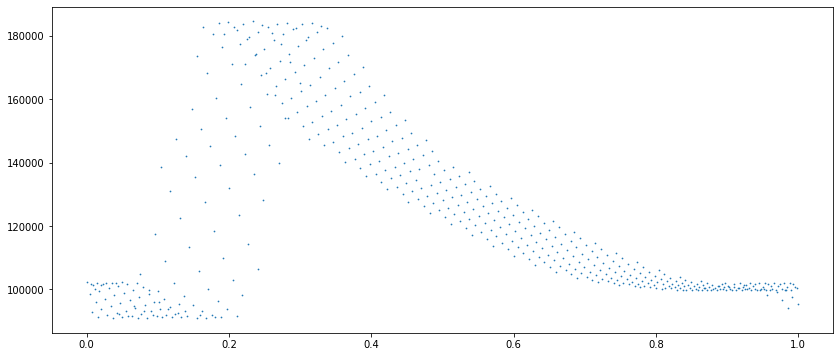

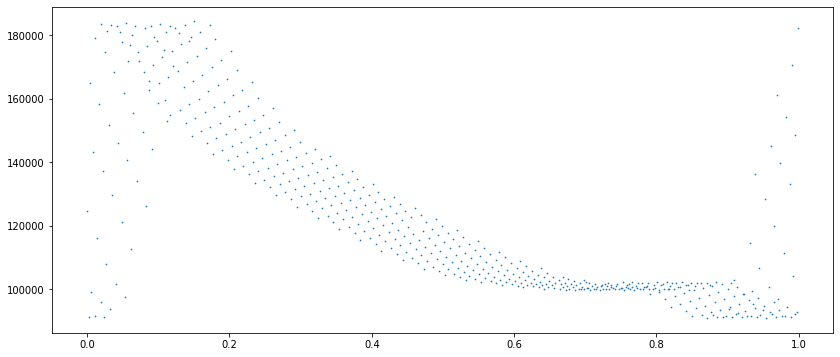

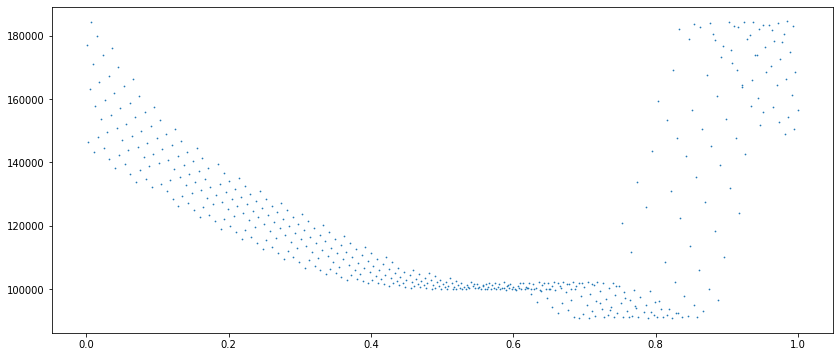

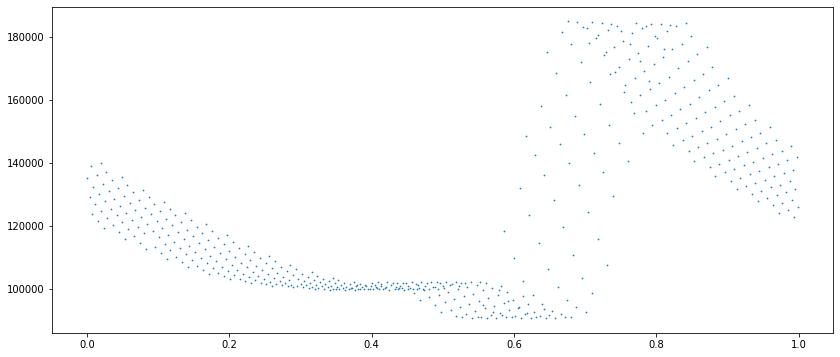

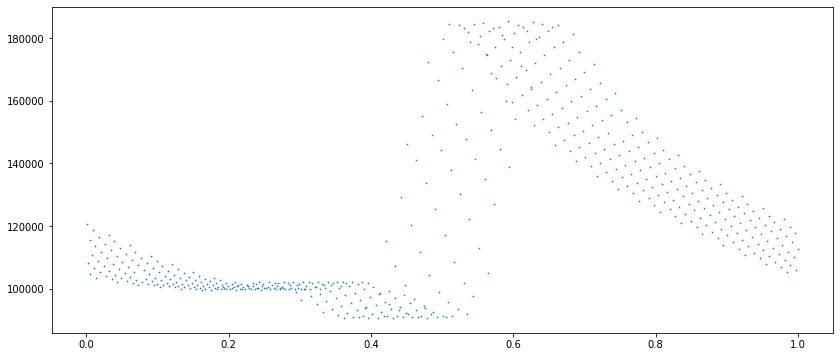

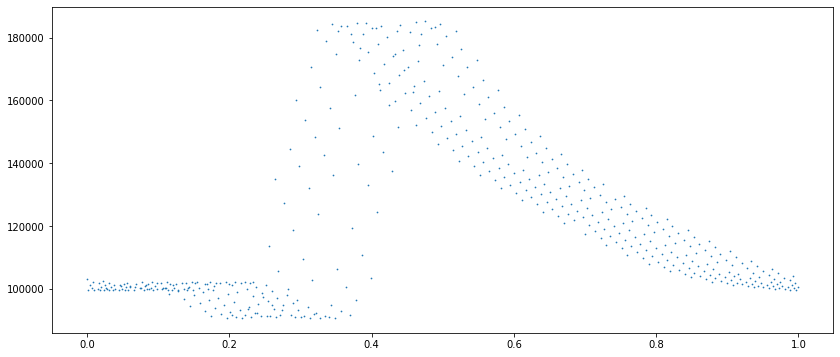

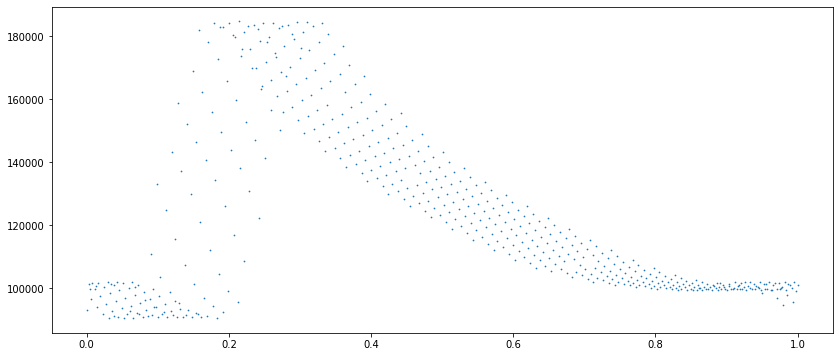

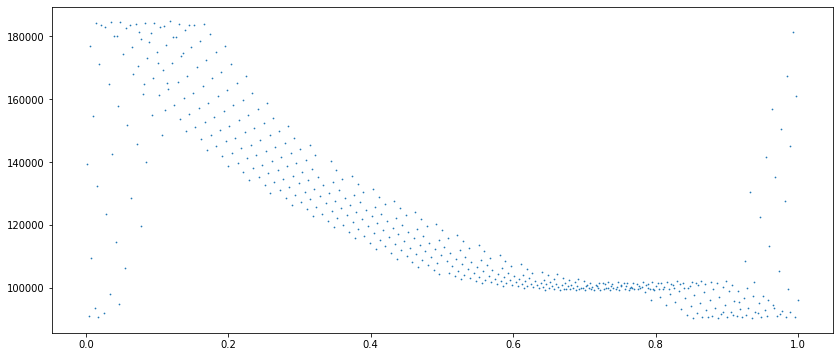

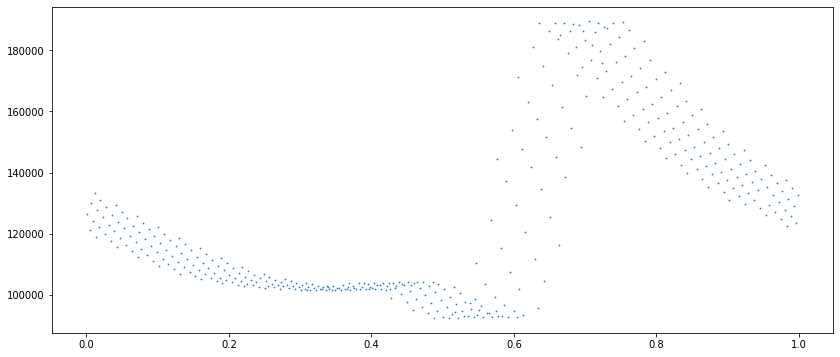

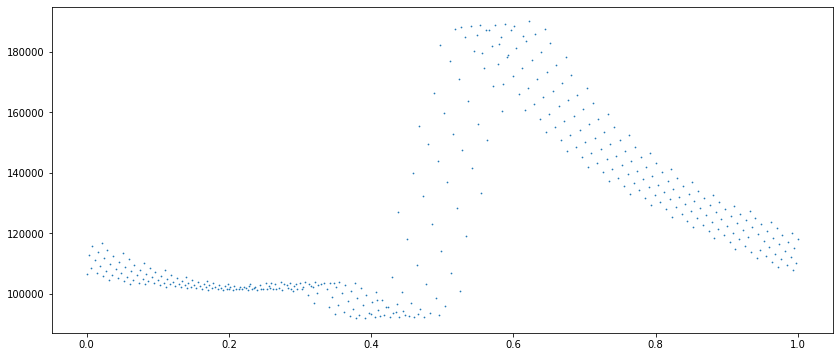

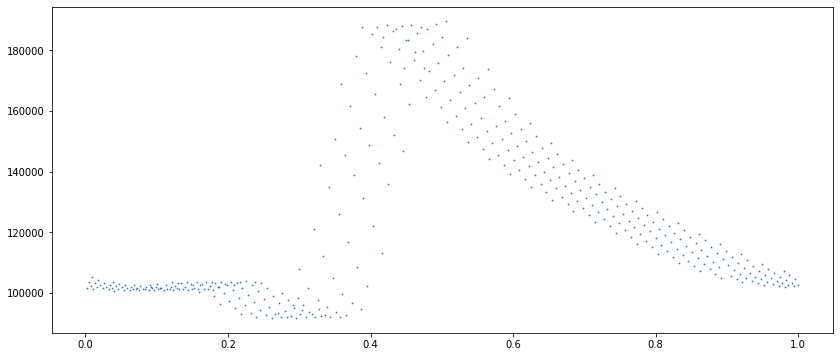

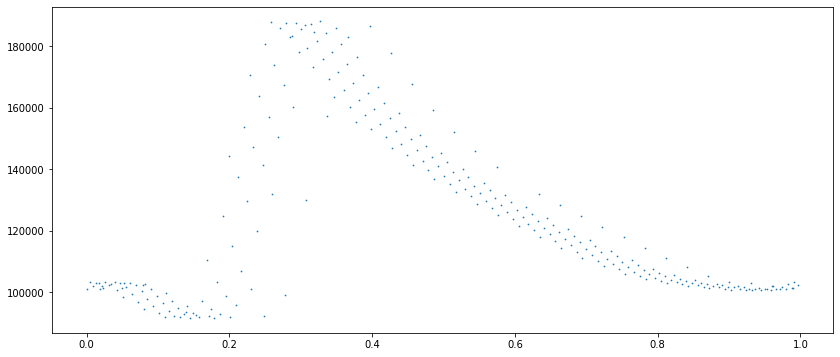

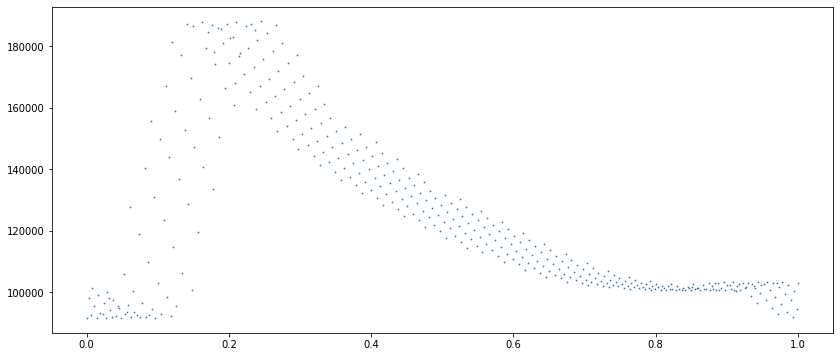

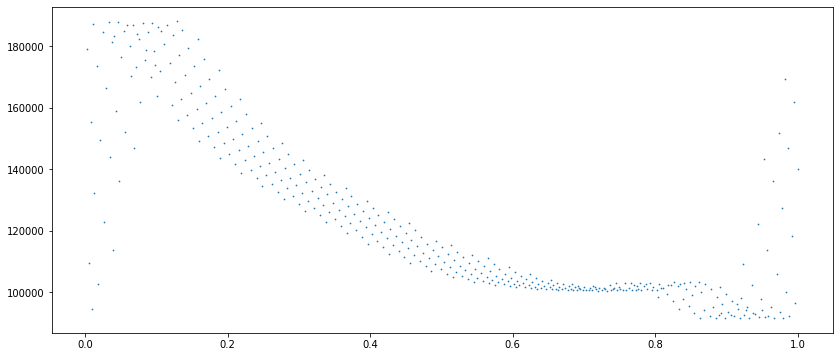

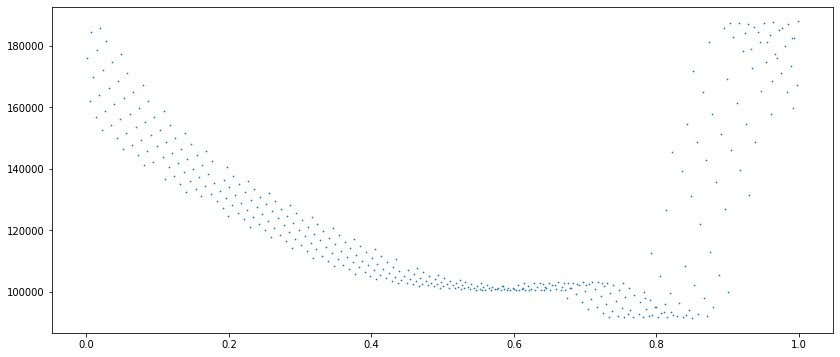

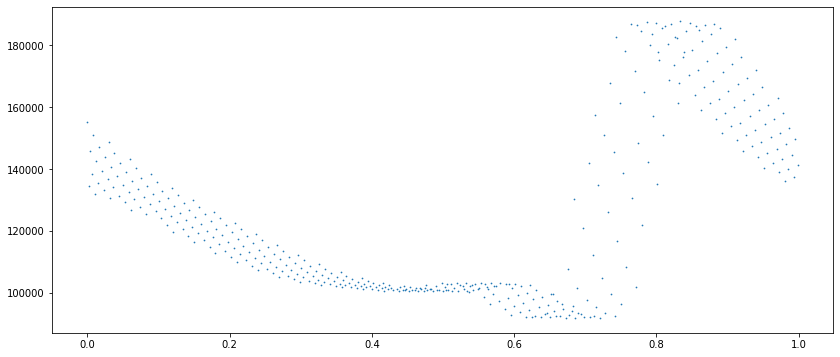

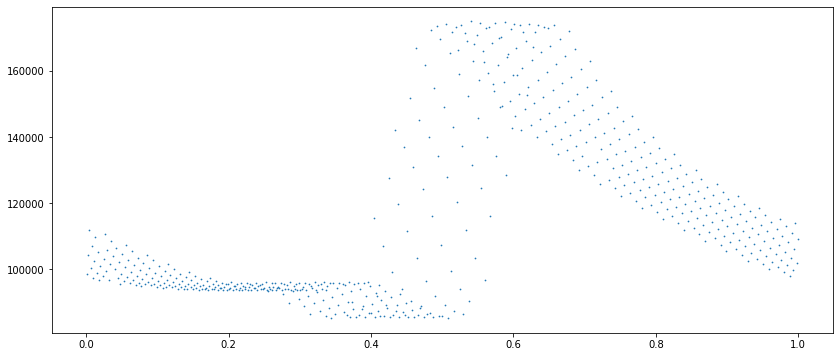

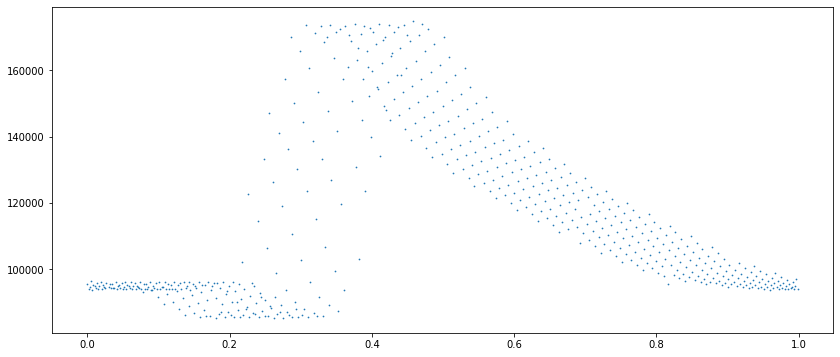

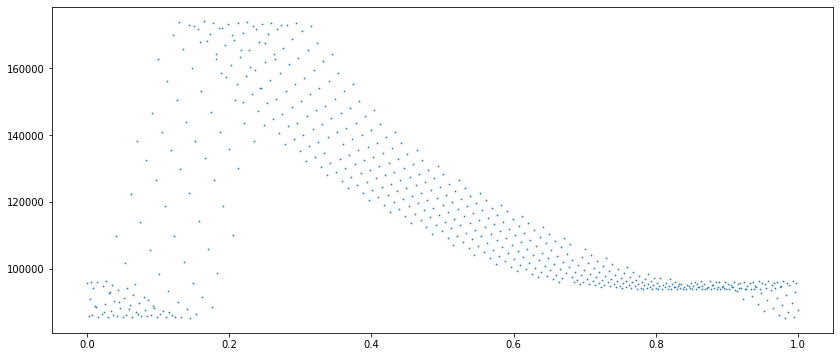

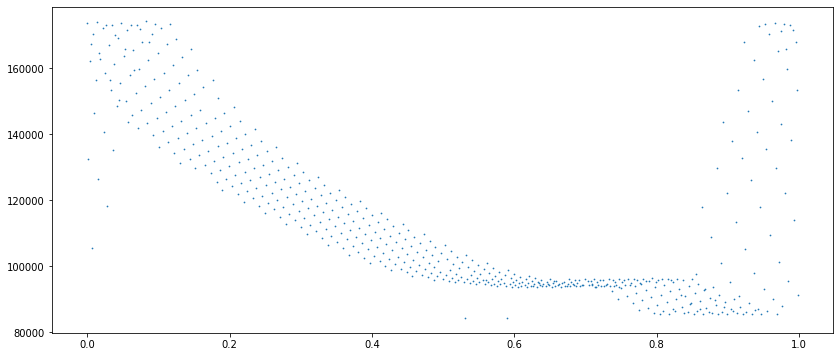

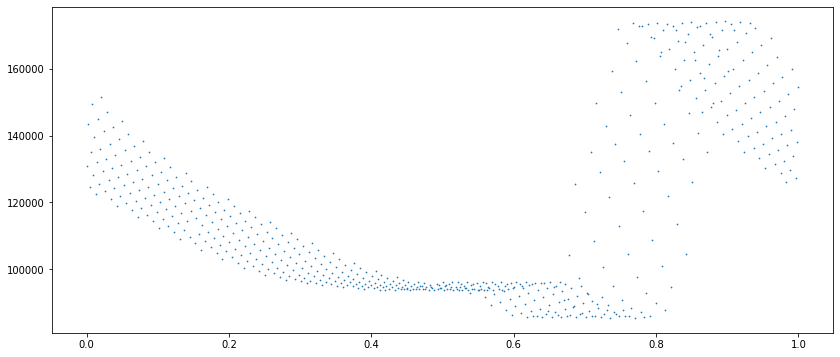

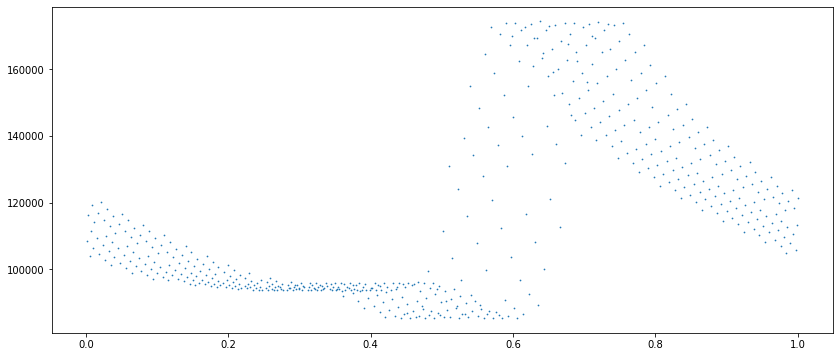

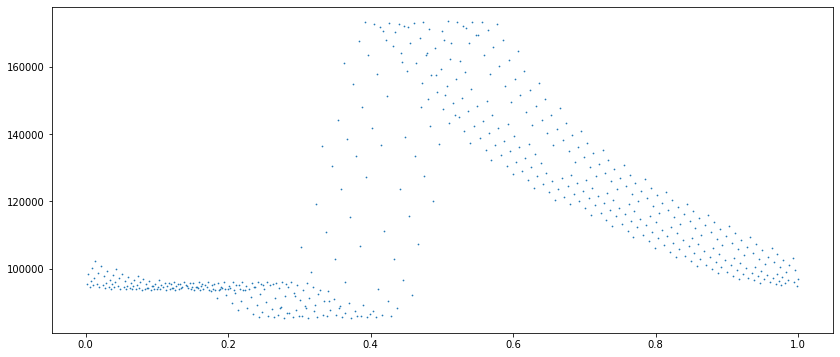

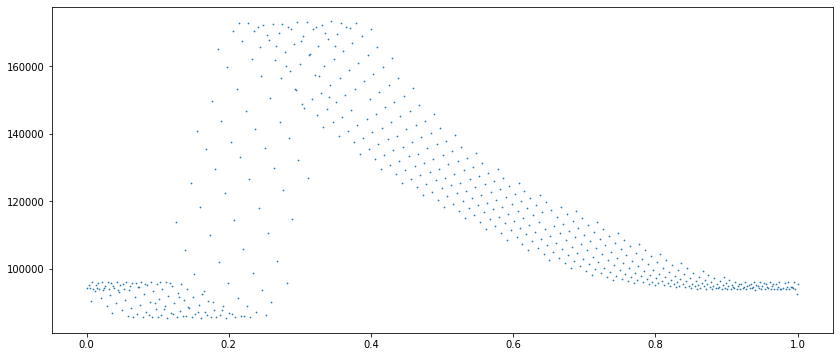

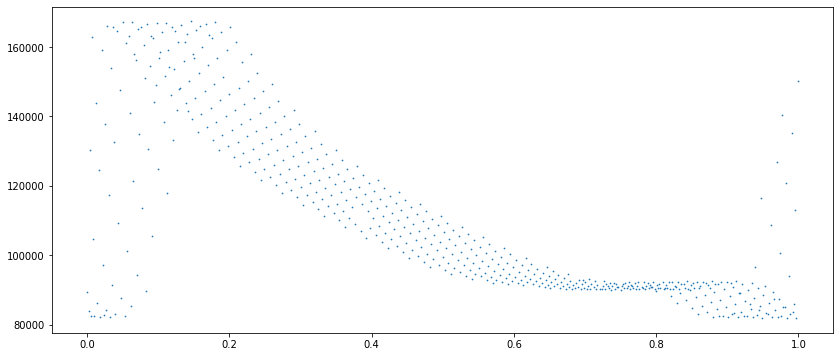

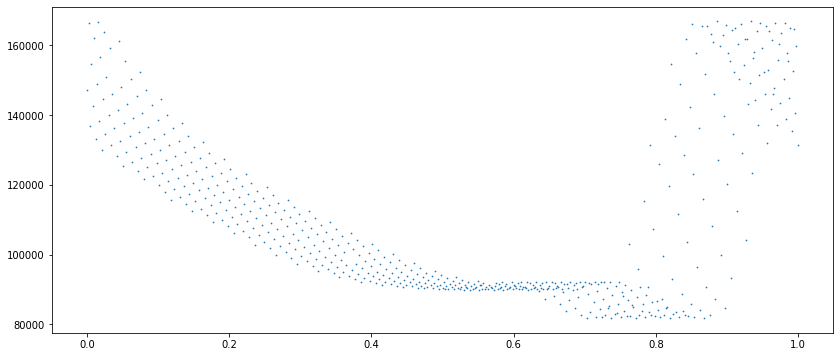

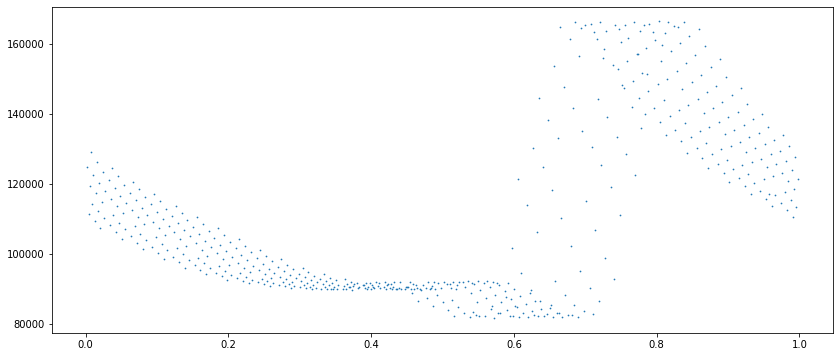

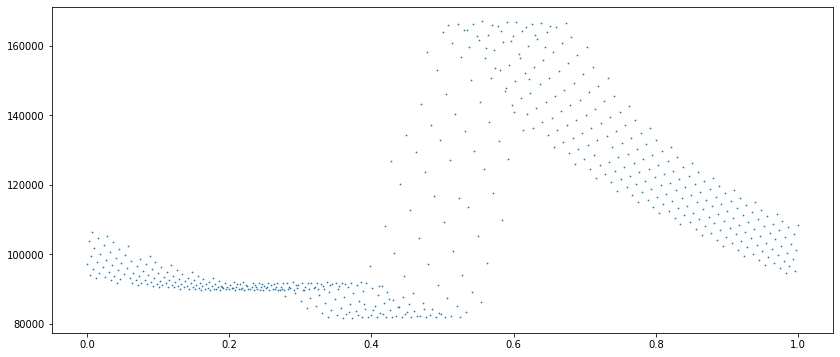

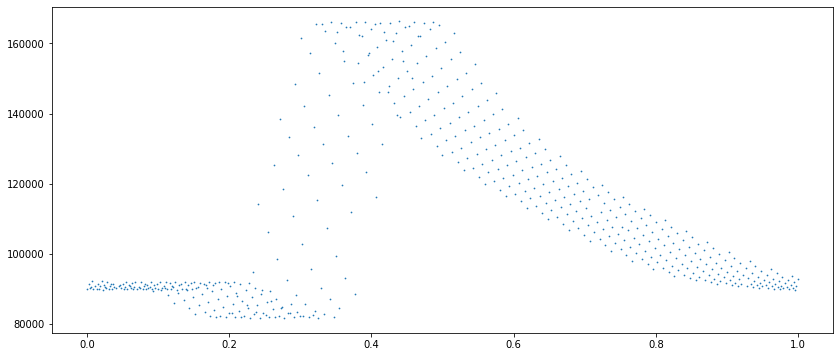

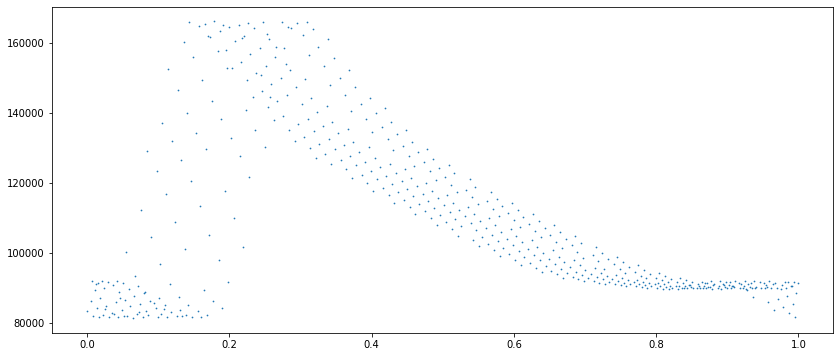

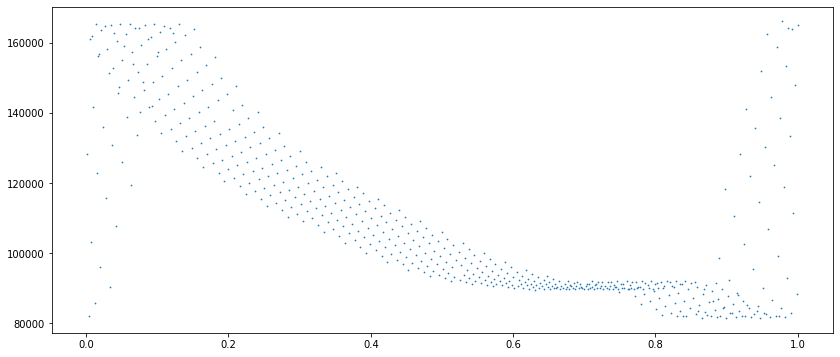

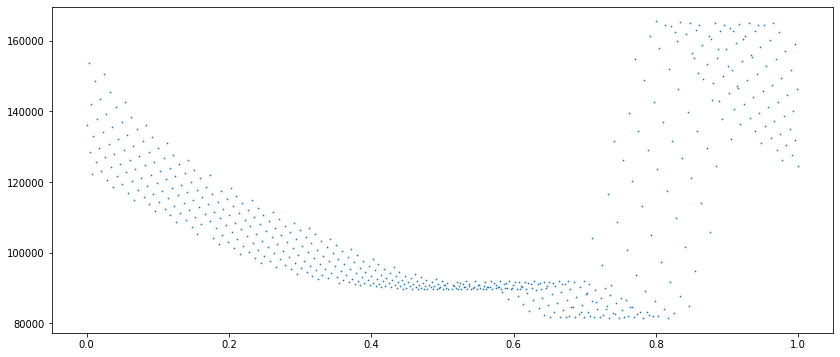

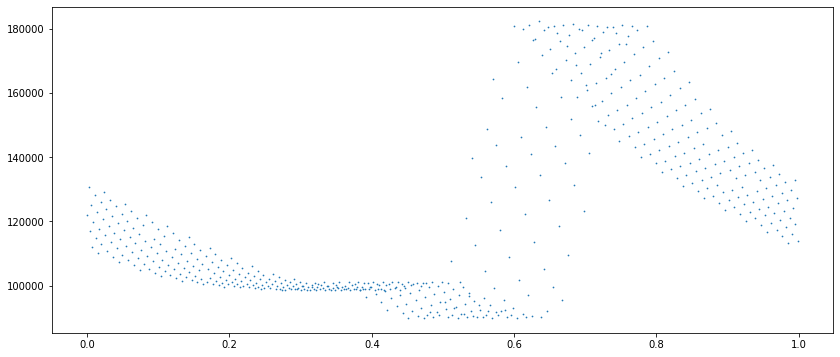

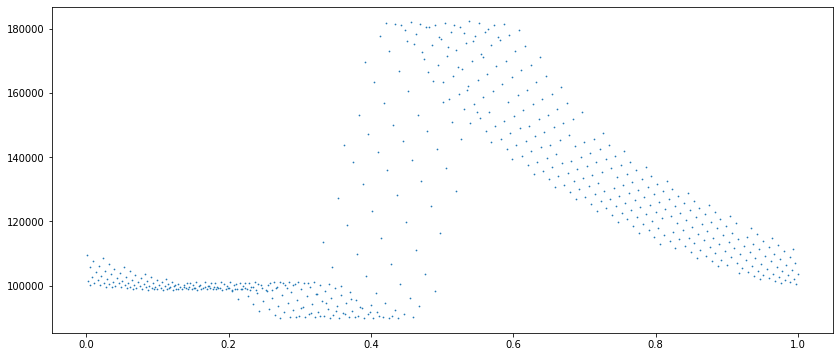

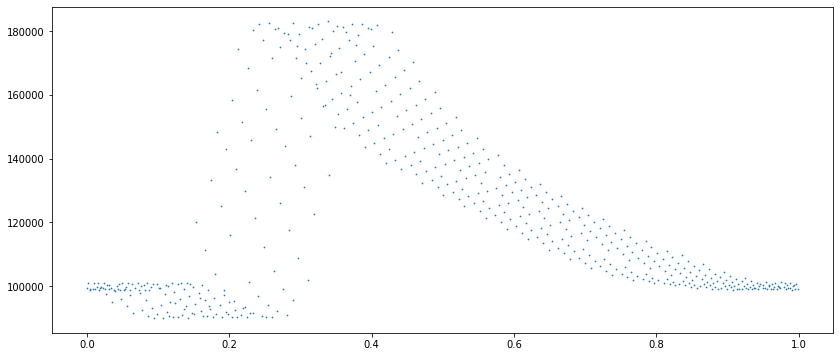

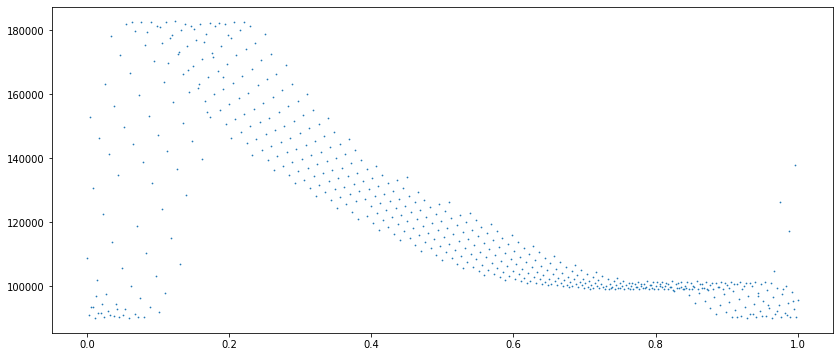

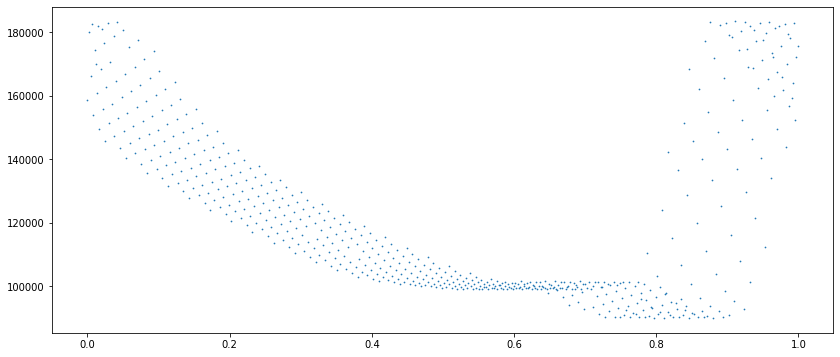

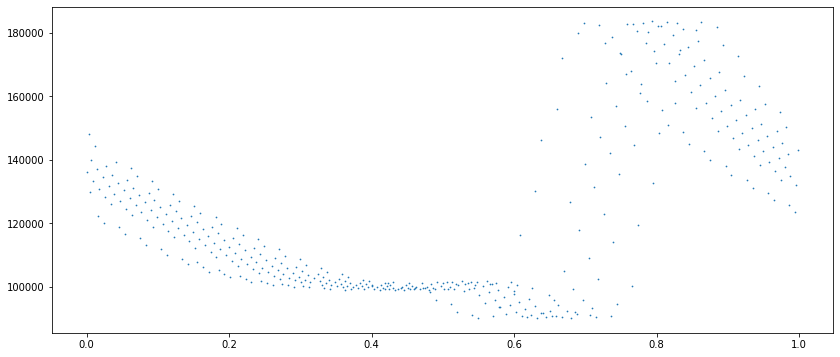

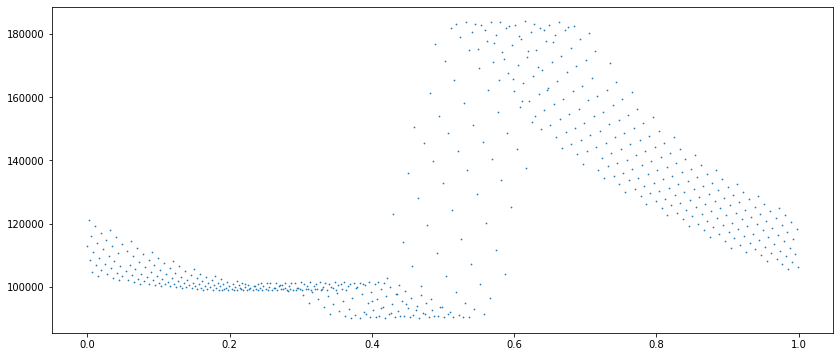

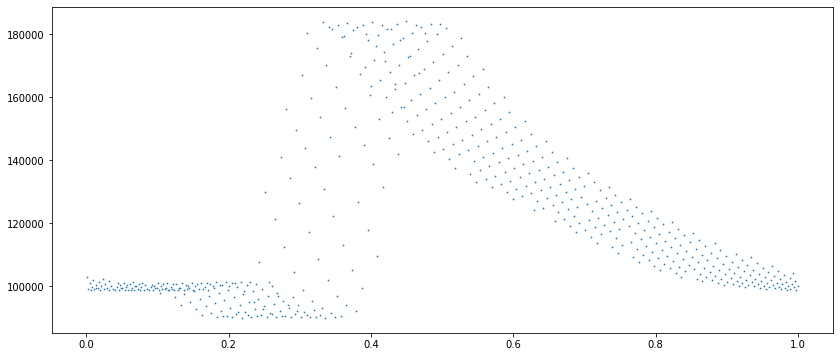

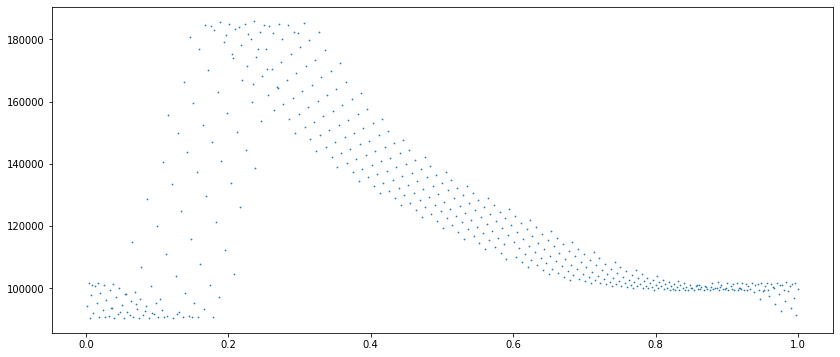

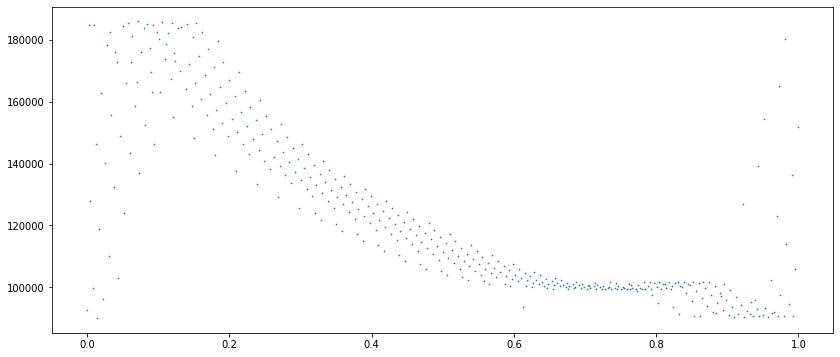

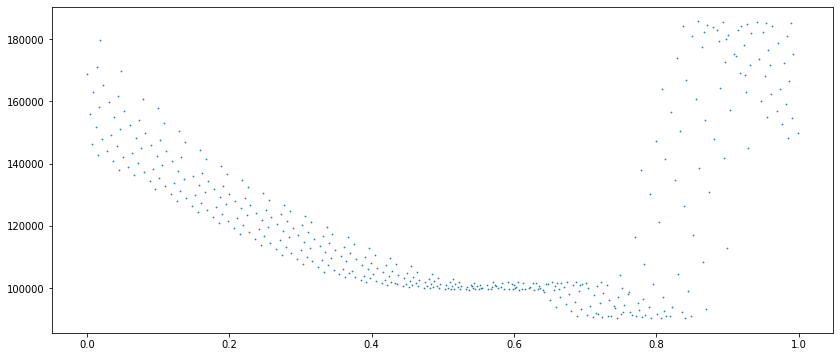

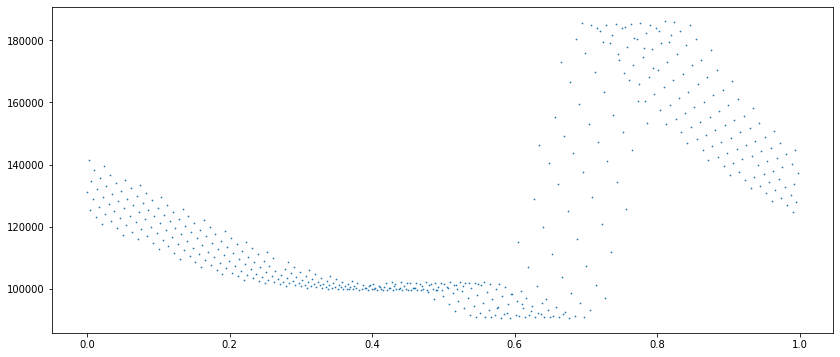

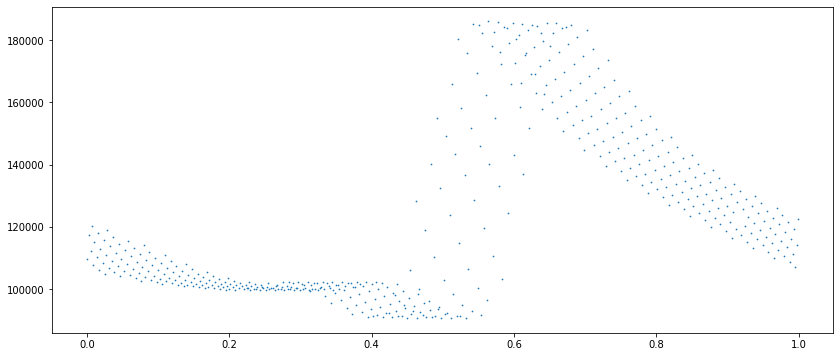

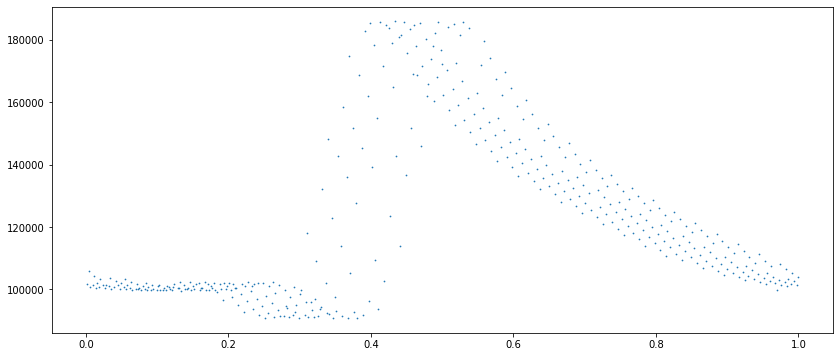

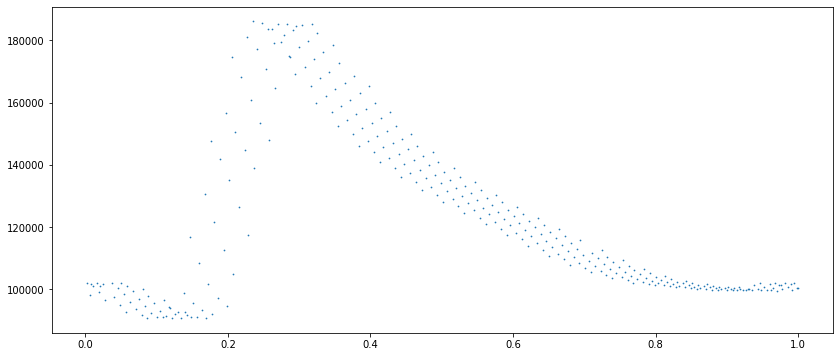

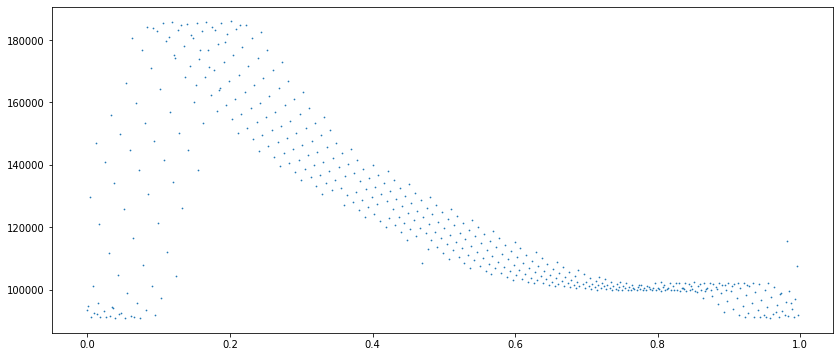

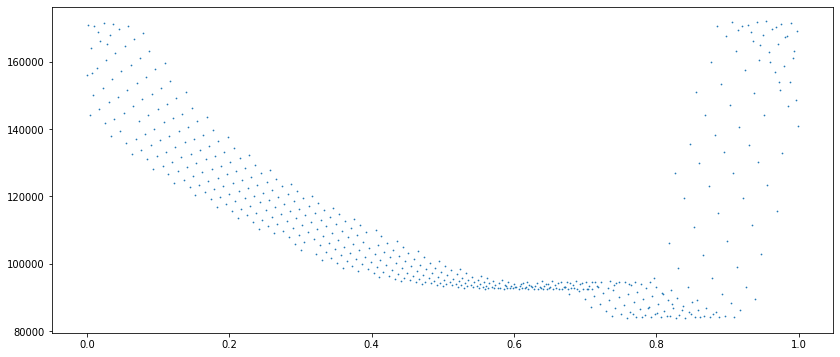

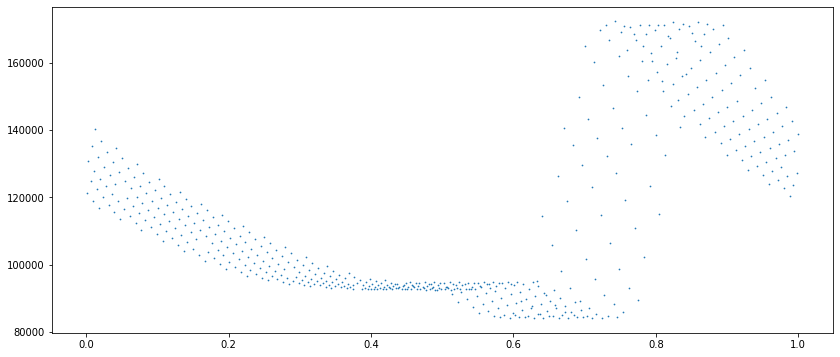

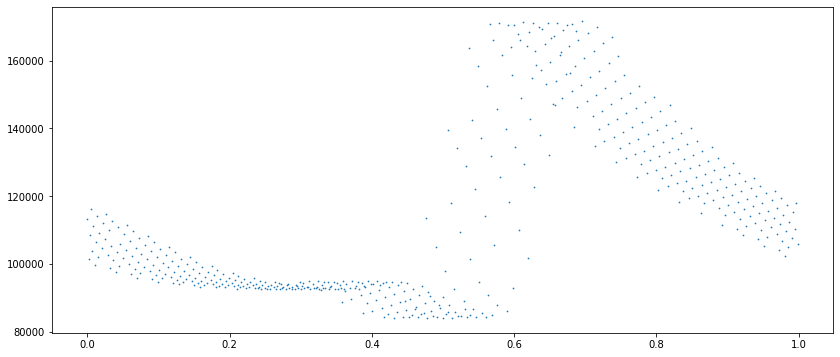

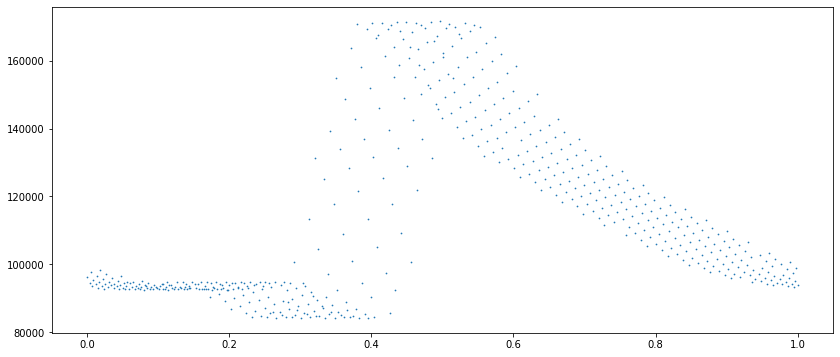

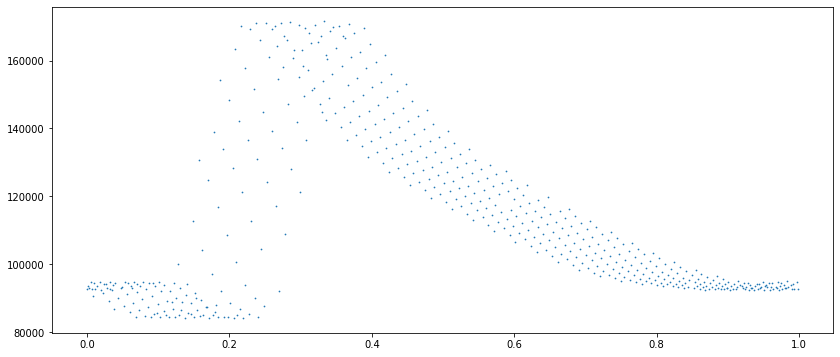

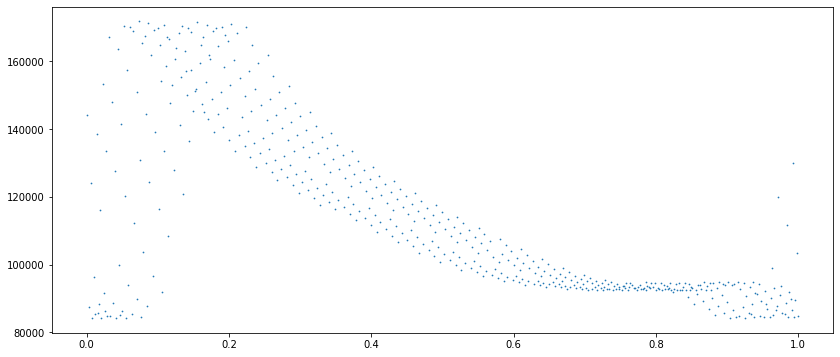

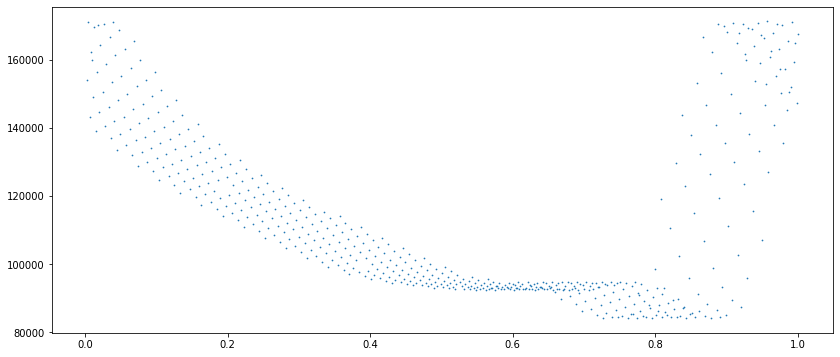

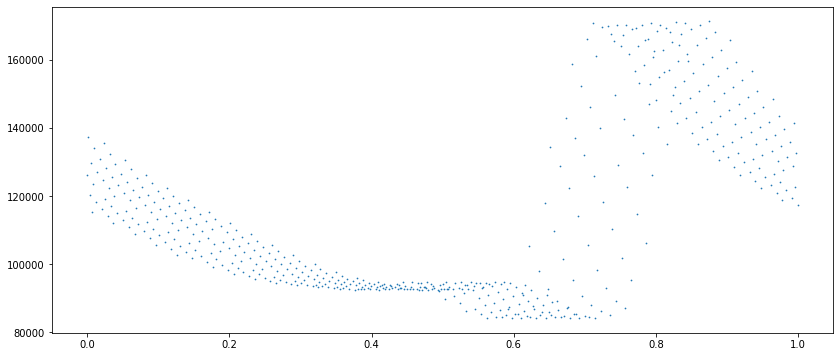

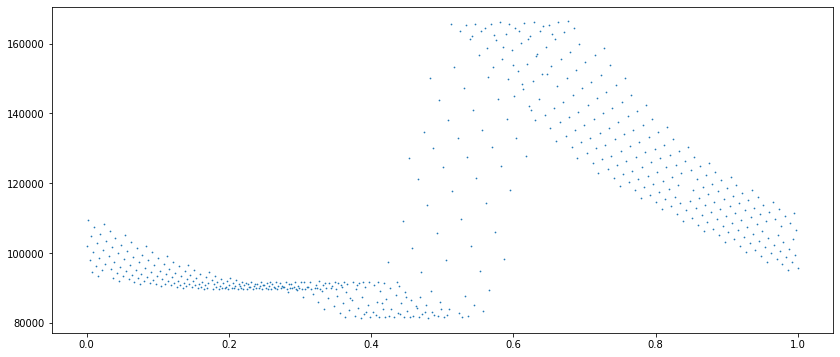

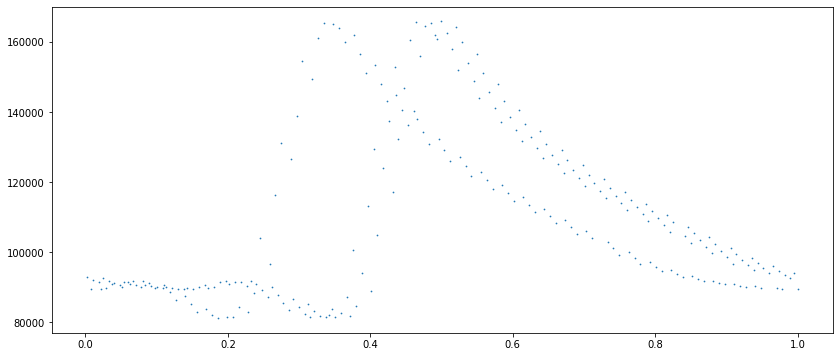

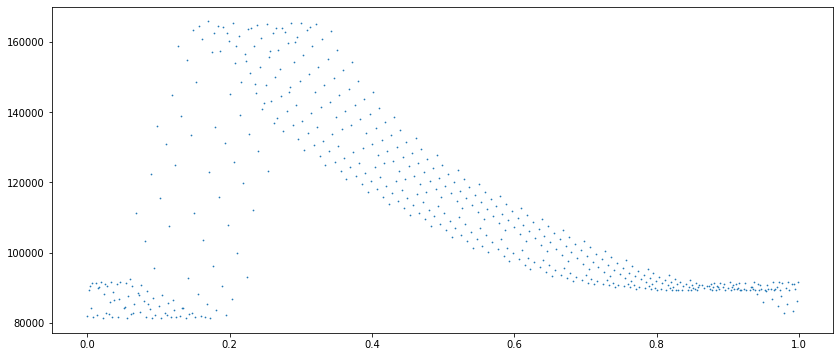

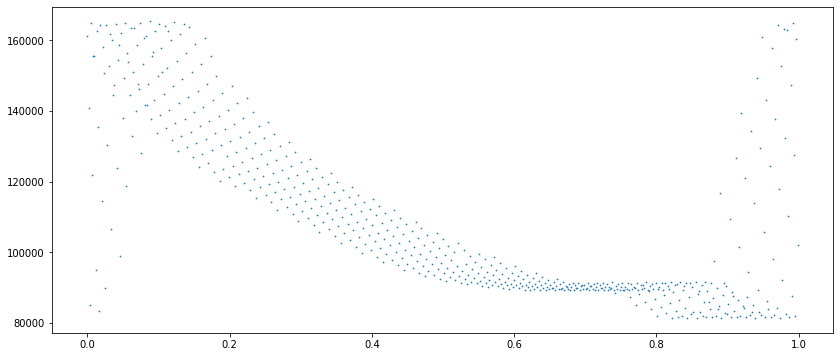

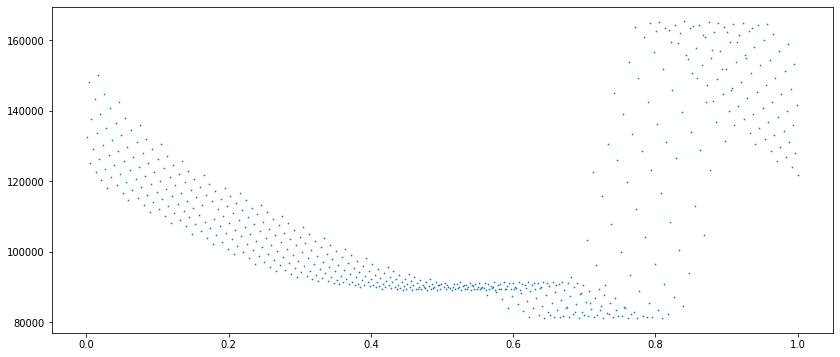

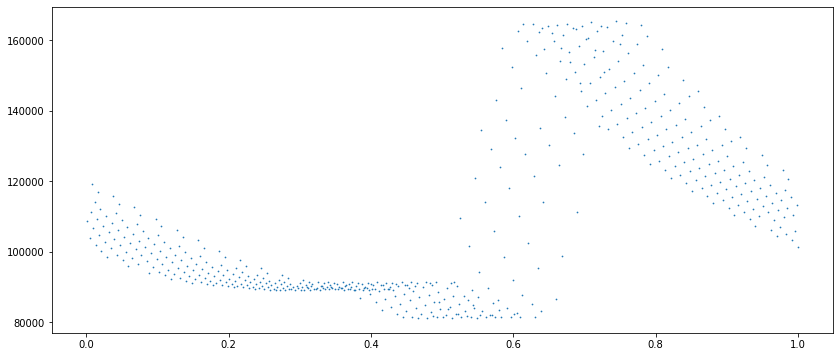

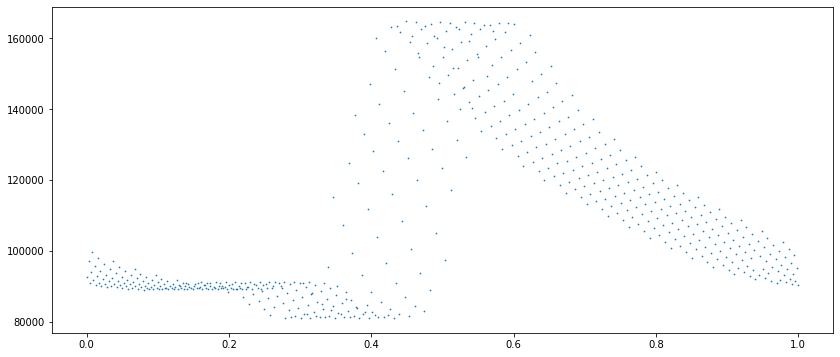

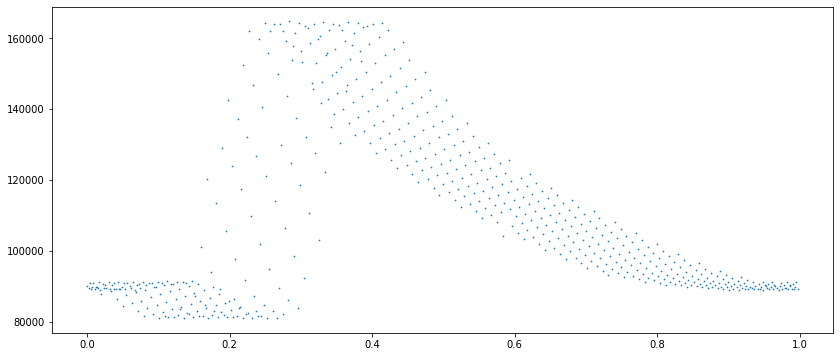

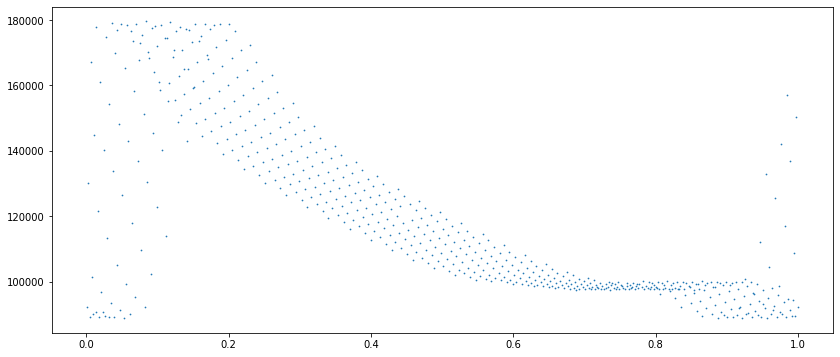

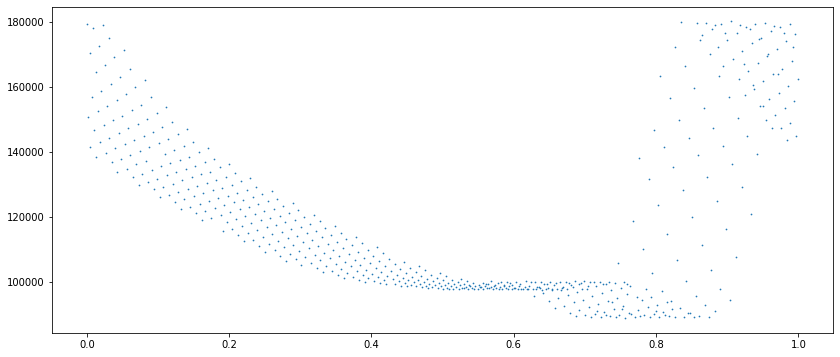

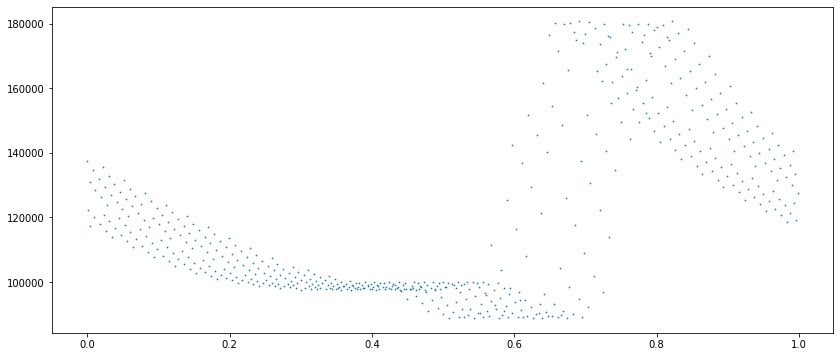

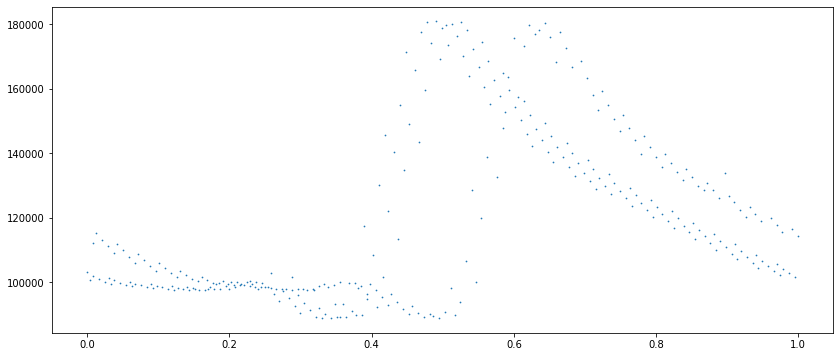

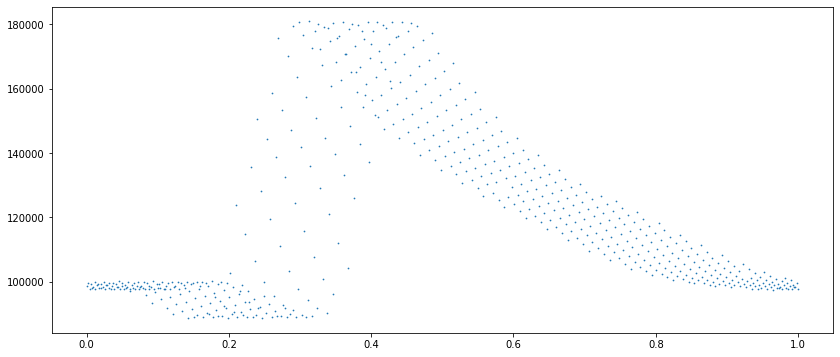

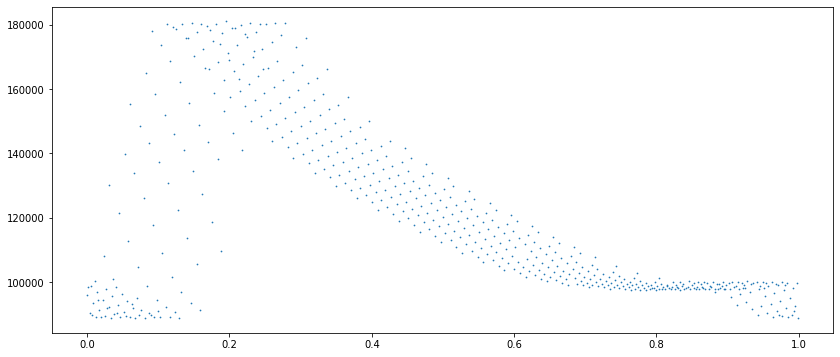

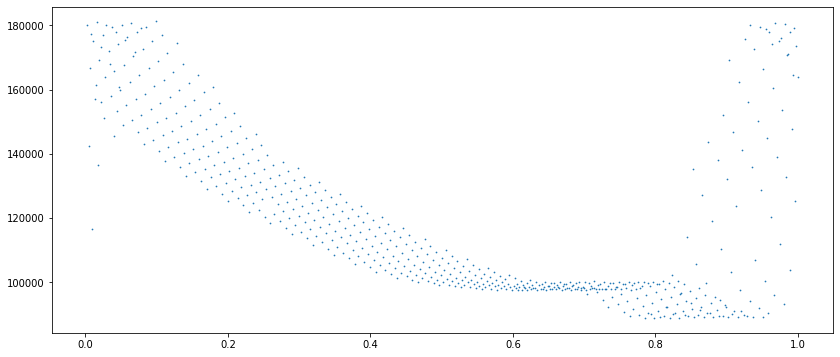

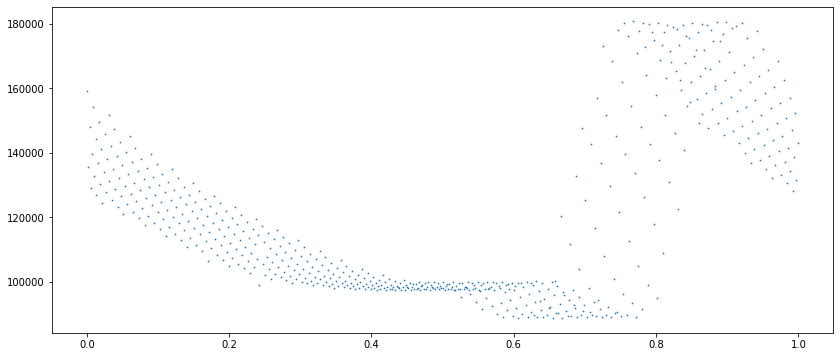

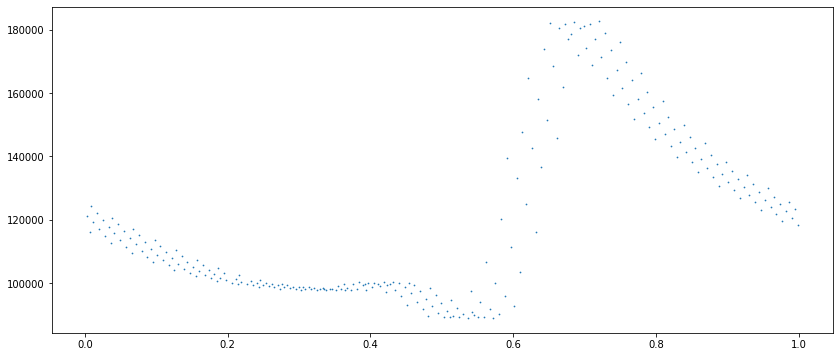

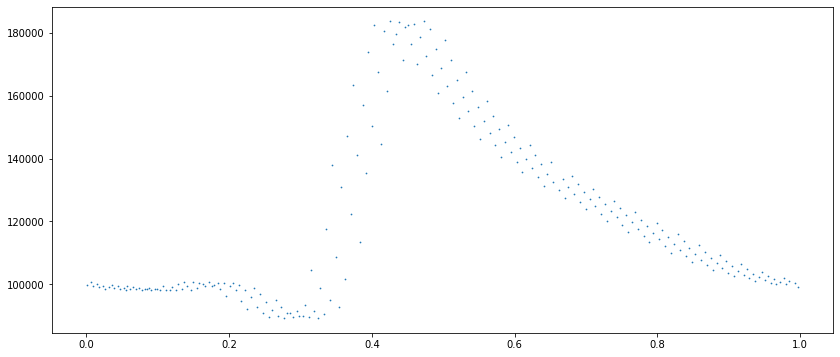

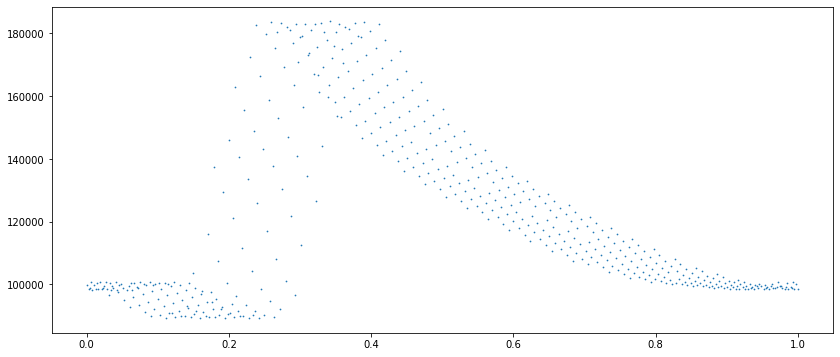

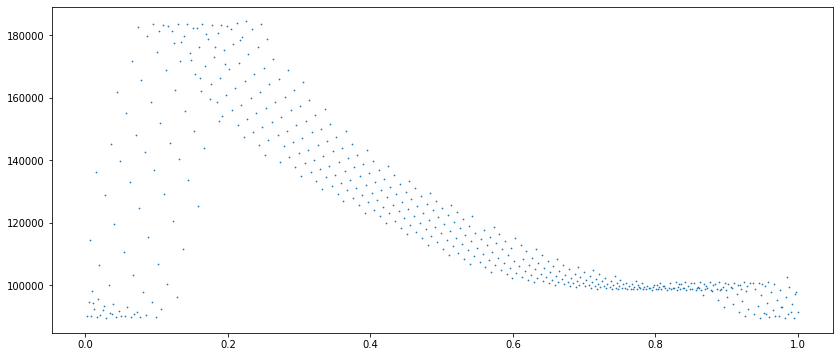

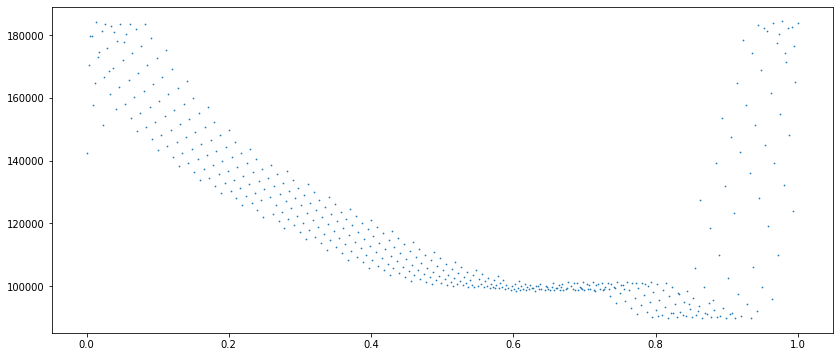

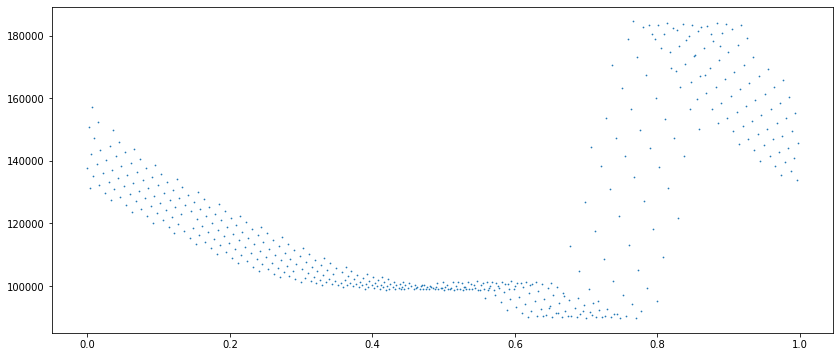

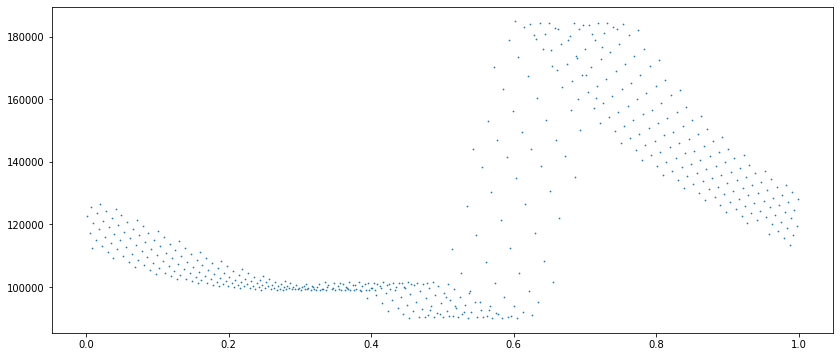

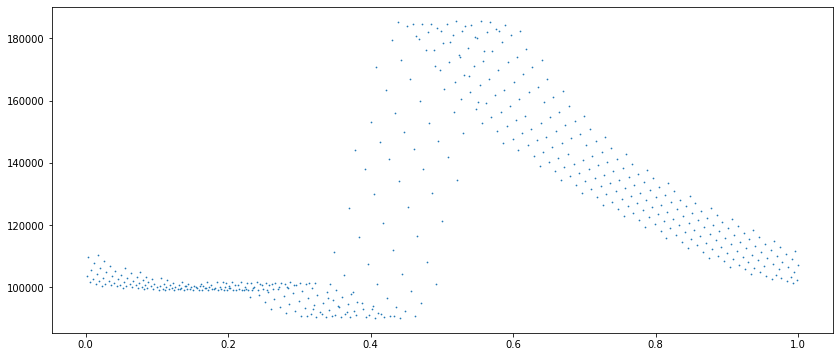

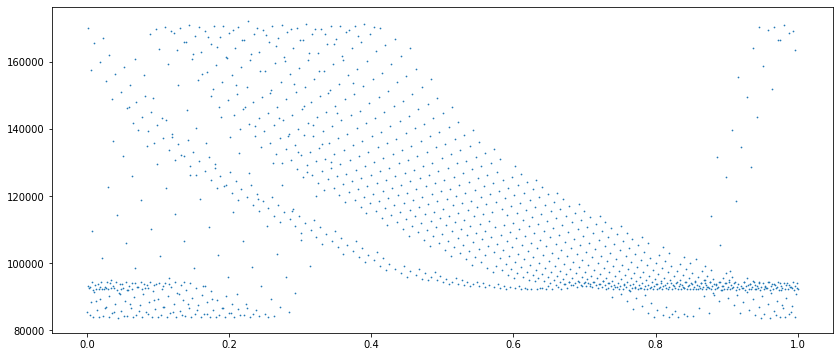

In [7]:
#plot folded data 

for key in data.keys():
    folded_bjds = (data[key]['bjds'] % period)/period

    fig = plt.figure(figsize=(14, 6))
    plt.scatter(folded_bjds, data[key]['pdcsap_fluxes'], s=0.5)
    plt.show()

In [8]:
scan_width = 0.0001
scan_n = 50
times = np.arange(period-scan_n*scan_width, period+scan_n*scan_width, scan_width)

#the optimizer
def likelihood(period, data, verbose_out=False):
   
    #fold the data based on the period
    folded_bjds = (data['bjds'] % period)/period
    
    #bin the data
    bin_width = 0.01
    binned_pdcsap_fluxes = []
    binned_bjds = []
    
    i = 0
    while i < 1:
        indx = (folded_bjds >= i)*(folded_bjds < i+bin_width)
        binned_pdcsap_fluxes.append(data['pdcsap_fluxes'][indx])
        binned_bjds.append(folded_bjds[indx])
        i += bin_width
    
    #compute the dispersion of each bin w.r.t. a linear fit:    
    #then adjust the data according to that linear fit
    slope_adj_fluxes = []
    lfs = []
    for i in range(len(binned_bjds)):
        indx = (np.logical_not(np.isnan(binned_bjds[i])))*(np.logical_not(np.isnan(binned_pdcsap_fluxes[i])))
        if len(binned_pdcsap_fluxes[i][indx]) == 0:
            slope_adj_fluxes.append([np.nan, np.nan, np.nan])
        else:
            lf = linregress(binned_bjds[i][indx], binned_pdcsap_fluxes[i][indx])
            lfs.append(lf)
            slope_adj_fluxes.append([binned_pdcsap_fluxes[i][indx][j] - (lf[0]*binned_bjds[i][indx][j] + lf[1]) for j in range(len(binned_pdcsap_fluxes[i][indx]))])
    
        #these are to plot the linear fits if we think there's a problem with those
        #fig = plt.figure(figsize=(6, 6))
        #plt.scatter(binned_bjds[i][indx], binned_pdcsap_fluxes[i][indx])
        #plt.plot([np.min(binned_bjds[i][indx]), np.max(binned_bjds[i][indx])], [lf[0]*np.min(binned_bjds[i][indx]) + lf[1], lf[0]*np.max(binned_bjds[i][indx]) + lf[1]], c='k', ls='--')
        #plt.show()
    
    disps = np.array([np.nanstd(f) for f in slope_adj_fluxes])
    for i in range(len(disps)):
        if len(binned_pdcsap_fluxes[i]) == 0:
            disps[i] = np.nan
    
    #likelihood score is just the sum of all dispersions
    penalty = 1000 #penalize not having anything in a bin
    like = np.nansum(disps**2)/len(disps[np.logical_not(np.isnan(disps))]) + len(disps[np.isnan(disps)])*penalty
    
    if verbose_out:
        return like, disps, lfs
    else:
        return like
    
#helper class for running threads and updating the lists
class ListDatabase:
    def __init__(self, n):
        self.best_periods = [0]*n
        self.all_likes = [0]*n

    def update_lists(self, pos, period, like):
        self.best_periods[pos] = period
        self.all_likes[pos] = like
        
    def get_lists(self):
        return self.best_periods, self.all_likes
    
    def calc_like(self, key):
        print('started thread', key)
        all_likes = []

        best_period = period
        best_like = likelihood(period, data[key])

        for p in times:
            like = likelihood(p, data[key])
            all_likes.append(like)
            if like < best_like:
                best_period = p
                best_like = like

        print('optimized split', key)
        self.update_lists(key, best_period, all_likes)

#brute force bc the likelihood surface isn't actually differentiable
#now with threading
def scan_time_slices(data):
    
    times = np.arange(period-scan_n*scan_width, period+scan_n*scan_width, scan_width)
    
    #create the helper db for the threads
    ldb = ListDatabase(len(data.keys()))

    with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
        for key in data.keys():
            executor.submit(ldb.calc_like, key)
    
    #extract the data from the db
    best_periods, all_like_list = ldb.get_lists()
        
    return best_periods, all_like_list

In [9]:
#optimize the period of each time slice
#best_periods = optimize_time_slices(data)
#best_periods = optimize_time_slices_de(data)
best_periods, all_like_list = scan_time_slices(data)
print('Optimized periods:', best_periods)

NameError: name 'concurrent' is not defined

In [ ]:
pickle_dir = '/home/donlon/Desktop/data/pickle/maps/'

with open(pickle_dir + 'best_periods_lowres.pickle', 'rb') as p:
    best_periods = pickle.load( p)

with open(pickle_dir + 'all_like_list_lowres.pickle', 'rb') as p:
    all_like_list = pickle.load(p)
    
scan_width = 0.00001
scan_n = 1e3
times = np.arange(period-scan_n*scan_width, period+scan_n*scan_width, scan_width)

In [ ]:
#find the "mean minimum" of all the likelihood surfaces
min_indx_list = []
for key in data.keys():
    min_indx = np.argmin(all_like_list[key])
    min_indx_list.append(min_indx)
mean_min_indx = int(np.mean(min_indx_list))

#plot likelihood surfaces
fit_periods = []
variances = []

for key in data.keys():
    fig = plt.figure(figsize=(14, 6))
    plt.plot(times, np.log(all_like_list[key]))

    min_indx = np.argmin(all_like_list[key])
    #indx = (np.abs(times - times[min_indx]) < 0.00001)
    pf = 0
    best_resid = np.nan
    
    #try fitting to a variety of scales
    #in order to try to find the actual best fitting parabola to the LS
    for indx in [np.abs(times - times[min_indx]) < tol for tol in np.linspace(10*scan_width, scan_width*scan_n, 10)]:
        polyf = polyfit(np.array(times)[indx], np.log(np.array(all_like_list)[key][indx]), 2, full=True)
        resid = polyf[1][0]/len(indx[indx]) #residual per datapoint
        if polyf[0][0] < 0:
            resid = 1e10
        if resid < best_resid or np.isnan(best_resid):
            best_resid = resid
            pf = polyf[0]
    plt.plot(times, pf[0]*times**2 + pf[1]*times + pf[2], c='r', lw=2, ls='--')
    
    fit_period = -pf[1]/(2*pf[0])
    variance = 1/(2*pf[0])
    
    fit_periods.append(fit_period)
    variances.append(variance)
    
    print('period:', fit_period)
    print('variance:', variance)
    
    xrange = np.max(times) - np.min(times)
    plt.xlim(times[mean_min_indx] - 0.025*xrange, times[mean_min_indx] + 0.025*xrange)
    plt.ylim(np.min(np.log(np.array(all_like_list)[key])),
             np.max(np.log(np.array(all_like_list)[key])))
    
    plt.show()
    
fit_periods = np.array(fit_periods)
variances = np.array(variances)

In [ ]:
#find the "mean minimum" of all the likelihood surfaces
min_indx_list = []
for key in data.keys():
    min_indx = np.argmin(all_like_list[key])
    min_indx_list.append(min_indx)
mean_min_indx = int(np.mean(min_indx_list))

#plot likelihood surfaces
fit_periods = []
variances = []

def func(data, a, b, c):
    return a*data**2 + b*data + c

for key in data.keys():
    fig = plt.figure(figsize=(14, 6))
    plt.plot(times, np.log(all_like_list[key]))

    min_indx = np.argmin(all_like_list[key])
    #indx = (np.abs(times - times[min_indx]) < 0.00001)
    best_pf = 0
    best_unc = np.nan
    
    #try fitting to a variety of scales
    #in order to try to find the actual best fitting parabola to the LS
    for indx in [np.abs(times - times[min_indx]) < tol for tol in np.linspace(10*scan_width, scan_width*scan_n, 50)]:
        polyf = curve_fit(func, np.array(times)[indx], np.log(np.array(all_like_list)[key][indx]))
        pf = polyf[0]
        pf_unc = np.sqrt(np.diag(polyf[1])) #diagonals of the covariance matrix for the fit
        fit_unc = ((1/(4*pf[0]**2))*((pf[1]/pf[0])**2 * pf_unc[0]**2 + pf_unc[1]**2))**0.5
        if polyf[0][0] < 0:
            fit_unc = 1e10
        if fit_unc < best_unc or np.isnan(best_unc):
            best_unc = fit_unc
            best_pf = pf
    plt.plot(times, best_pf[0]*times**2 + best_pf[1]*times + best_pf[2], c='r', lw=2, ls='--')
    
    fit_period = -best_pf[1]/(2*best_pf[0])
    mle_unc = 1/(2*best_pf[0])
    variance = (best_unc**2 + fit_unc**2)**0.5 #idk what else to do but add them in quadrature
    
    fit_periods.append(fit_period)
    variances.append(variance)
    
    print('period:', fit_period)
    print('variance:', variance)
    
    xrange = np.max(times) - np.min(times)
    plt.xlim(times[min_indx] - 0.1*xrange, times[min_indx] + 0.1*xrange)
    plt.ylim(np.min(np.log(np.array(all_like_list)[key])),
             np.max(np.log(np.array(all_like_list)[key])))
    
    plt.show()
    
fit_periods = np.array(fit_periods)
variances = np.array(variances)

In [ ]:
#find the "mean minimum" of all the likelihood surfaces
min_indx_list = []
for key in data.keys():
    min_indx = np.argmin(all_like_list[key])
    min_indx_list.append(min_indx)
mean_min_indx = int(np.mean(min_indx_list))

#plot likelihood surfaces
fit_periods = []
variances = []

def func(data, a, b, c):
    return a*data**2 + b*data + c

for key in data.keys():
    fig = plt.figure(figsize=(14, 6))
    plt.plot(times, np.log(all_like_list[key]))

    best_pf = 0
    best_unc = np.nan
    
    #try fitting to a variety of scales
    #in order to try to find the actual best fitting parabola to the LS
    for indx in [np.abs(times - times[mean_min_indx]) < tol for tol in np.linspace(10*scan_width, scan_width*scan_n, 50)]:
        polyf = curve_fit(func, np.array(times)[indx], np.log(np.array(all_like_list)[key][indx]))
        pf = polyf[0]
        pf_unc = np.sqrt(np.diag(polyf[1])) #diagonals of the covariance matrix for the fit
        fit_unc = ((1/(4*pf[0]**2))*((pf[1]/pf[0])**2 * pf_unc[0]**2 + pf_unc[1]**2))**0.5
        if polyf[0][0] < 0:
            fit_unc = 1e10
        if fit_unc < best_unc or np.isnan(best_unc):
            best_unc = fit_unc
            best_pf = pf
    plt.plot(times, best_pf[0]*times**2 + best_pf[1]*times + best_pf[2], c='r', lw=2, ls='--')
    
    fit_period = -best_pf[1]/(2*best_pf[0])
    mle_unc = 1/(2*best_pf[0])
    variance = (best_unc**2 + fit_unc**2)**0.5 #idk what else to do but add them in quadrature
    
    fit_periods.append(fit_period)
    variances.append(variance)
    
    print('period:', fit_period)
    print('variance:', variance)
    
    plt.ylim(np.min(np.log(np.array(all_like_list)[key])),
             np.max(np.log(np.array(all_like_list)[key])))
    
    plt.show()
    
fit_periods = np.array(fit_periods)
variances = np.array(variances)

In [ ]:
# #re-run the parameter sweep, but on high-resolution now
# scan_width = 0.000005
# scan_n = 1e3
# period = times[mean_min_indx]
# times = np.arange(period-scan_n*scan_width, period+scan_n*scan_width, scan_width)

# #optimize the period of each time slice
# #best_periods = optimize_time_slices(data)
# #best_periods = optimize_time_slices_de(data)
# best_periods, all_like_list = scan_time_slices(data)
# print('Optimized periods:', best_periods)

In [ ]:
pickle_dir = '/home/donlon/Desktop/data/pickle/maps/'

with open(pickle_dir + 'best_periods_highres.pickle', 'rb') as p:
    best_periods = pickle.load( p)

with open(pickle_dir + 'all_like_list_highres.pickle', 'rb') as p:
    all_like_list = pickle.load(p)
    
scan_width = 0.0000005
scan_n = 1e3
times = np.arange(period-scan_n*scan_width, period+scan_n*scan_width, scan_width)

In [ ]:
#this optimizer optimizes a parabola to the minimum of the likelihood surface

def func(params, datax):
    return params[0]*datax**2 + params[1]*datax + params[2]

def rss(params, datax, datay):
    resid = np.sum((datay - func(params, datax))**2)/(len(datax - 3)) #reduced chi squared
    return resid
'''
#hessian calculating stuff

#compute numerical second derivative w.r.t ith and jth parameters
def der2(fun, params, i, j, datax, datay):
    
    dt = 1e-3
    
    paramsl = params.copy()
    paramsl[i] -= dt
    paramsl[j] -= dt
    evall = rss(paramsl, datax, datay)
    
    evalc = rss(params, datax, datay)
    
    paramsr = params.copy()
    paramsr[i] += dt
    paramsr[j] += dt
    evalr = rss(paramsr, datax, datay)
    
    return (evall + evalr - 2*evalc)/dt**2

def get_hess_inv(fun, params, datax, datay):
    
    #build the hessian
    hess = np.zeros([len(params), len(params)])
    for i in len(params):
        for j in len(params):
            hess[i][j] = der2(fun, params, i, j, datax, datay)
    
    #invert it and compute variances
'''

def OLS_uncertainty(datax, params, resid):
    
    #scale the data so min=-1, max=1, mean=0
    scaled_dx = datax - np.mean(datax)
    scaled_dx /= np.max(scaled_dx)
    
    xmat = np.array([[i**2, i, 1] for i in scaled_dx])
    cov = np.linalg.inv(np.matmul(xmat.T, xmat))
    
    return np.sqrt(resid*np.diag(cov))


In [ ]:
#find the "mean minimum" of all the likelihood surfaces
min_indx_list = []
for key in data.keys():
    min_indx = np.argmin(all_like_list[key])
    min_indx_list.append(min_indx)
mean_min_indx = int(np.median(min_indx_list))

#plot likelihood surfaces
fit_periods = []
variances = []

for key in data.keys():
    fig = plt.figure(figsize=(14, 6))
    plt.plot(times, np.log(all_like_list[key]))

    #setting up the context
    min_indx = np.argmin(all_like_list[key])
    best_popt = np.nan
    best_resid = np.nan
    best_indx = np.nan
    
    #construct the guess for the optimized parabola (this is a lot of algebra)
    left_dist = 100
    yleft = np.log(all_like_list[key][min_indx - left_dist])
    xleft = times[min_indx - left_dist]
    ymin = np.log(all_like_list[key][min_indx])
    xmin = times[min_indx]
    aguess = (yleft - ymin)/(xleft**2 - 2*xleft*xmin + xmin**2)
    cguess = ymin + xmin**2*aguess
    bguess = -2*aguess*times[min_indx]
    x0 = [aguess, bguess, cguess]
    print(x0)
    
    #try fitting to a variety of scales
    #in order to try to find the actual best fitting parabola to the LS
    for indx in [np.abs(times - times[mean_min_indx]) < tol for tol in np.linspace(50*scan_width, scan_width*scan_n, 50)]:
        result = minimize(rss, x0, args=(np.array(times)[indx], np.log(np.array(all_like_list)[key][indx])),
                         method='Nelder-Mead')
        params = result.x
        #hess_inv = result.hess_inv
        resid = result.fun
        #print('no. iterations', result.nit)
        #print('resid:', resid)
        
        if popt[0] < 0: #negative 2nd derivative, bad fit & no uncertainty measurement
            resid = 1e10 #just set this as something enormous
        if resid < best_resid or np.isnan(best_resid):
            #print('replacing best option')
            best_resid = resid
            best_popt = params
            best_indx = indx

    print(best_popt)
    plt.plot(times, best_popt[0]*times**2 + best_popt[1]*times + best_popt[2], c='r', lw=2, ls='--')
    
    #period and uncertainty calculations
    fit_period = -best_popt[1]/(2*best_popt[0])
    mle_unc = 1/(2*best_popt[0])
    punc = OLS_uncertainty(times[best_indx], best_popt, best_resid)
    #print('uncertainties:', punc)
    best_fit_unc = ((1/(4*best_popt[0]**2))*((best_popt[1]/best_popt[0])**2 * punc[0]**2 + punc[1]**2))**0.5
    #print('fit_unc:', best_fit_unc)
    variance = (best_fit_unc**2 + mle_unc**2)**0.5 #idk what else to do but add them in quadrature
    
    fit_periods.append(fit_period)
    variances.append(variance)
    
    print('period:', fit_period)
    print('variance:', variance)
    
    xrange = np.max(times) - np.min(times)
    #plt.xlim(times[min_indx] - xrange, times[min_indx] + xrange)
    plt.ylim(np.nanmin(np.log(np.array(all_like_list)[key])),
             np.nanmax(np.log(np.array(all_like_list)[key])))
    
    plt.show()
    
fit_periods = np.array(fit_periods)
variances = np.array(variances)

In [ ]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='coif4', level=1): #db4 #coif8
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

#numerical 2nd derivative at indx, with step size dindx (in indices)
def der2(x, y, indx, dindx):
    
    left = y[indx - dindx]
    center = y[indx]
    right = y[indx + dindx]
    
    dt = np.abs(x[0] - x[dindx]) #assuming uniform step size
    
    return (left + right - 2*center)/dt**2

#find the "mean minimum" of all the likelihood surfaces
min_indx_list = []
for key in data.keys():
    min_indx = np.argmin(all_like_list[key])
    min_indx_list.append(min_indx)
mean_min_indx = int(np.median(min_indx_list))
print(mean_min_indx)
print(len(times))

dist = 300 #distance from mean min to check for wt min
indx = (np.abs(np.arange(0,len(times)) - mean_min_indx) < dist)

fit_periods = []
variances = []

for key in data.keys():
    fig = plt.figure(figsize=(14, 6))
    plt.plot(times, np.log(all_like_list[key]))
    
    y = wavelet_denoising(np.log(all_like_list[key]))
    plt.plot(times, y)
    
    min_indx = np.argmin(y[indx]) + (mean_min_indx - dist)
    
    d2 = der2(times, y, min_indx, 10)
    
    plt.scatter(times[min_indx], y[min_indx], s=50, c='r', zorder=99)
    plt.scatter(times[indx], y[indx], s=10, c='b')
    
    fit_period = times[min_indx]
    variance = 1/(2*d2)
    
    fit_periods.append(fit_period)
    variances.append(variance)
    
    print('period:', fit_period)
    print('variance:', variance)
    
#     log_like = np.log(np.array(all_like_list)[key])
#     for i, l in enumerate(log_like):
#         if l == -np.inf:
#             log_like[i] = np.nan
#     plt.ylim(np.nanmin(log_like), np.nanmax(log_like))
    plt.show()
    
fit_periods = np.array(fit_periods)
variances = np.array(variances)

In [ ]:
#find the "mean minimum" of all the likelihood surfaces
min_indx_list = []
for key in data.keys():
    min_indx = np.argmin(all_like_list[key])
    min_indx_list.append(min_indx)
mean_min_indx = int(np.median(min_indx_list))

#plot likelihood surfaces
fit_periods = []
variances = []

for key in data.keys():
    fig = plt.figure(figsize=(14, 6))
    plt.plot(times, np.log(all_like_list[key]))

    #setting up the context
    min_indx = np.argmin(all_like_list[key])
    best_popt = np.nan
    best_resid = np.nan
    best_indx = np.nan
    
    #construct the guess for the optimized parabola (this is a lot of algebra)
    left_dist = 100
    yleft = np.log(all_like_list[key][min_indx - left_dist])
    xleft = times[min_indx - left_dist]
    ymin = np.log(all_like_list[key][min_indx])
    xmin = times[min_indx]
    aguess = (yleft - ymin)/(xleft**2 - 2*xleft*xmin + xmin**2)
    cguess = ymin + xmin**2*aguess
    bguess = -2*aguess*times[min_indx]
    x0 = [aguess, bguess, cguess]
    print(x0)
    
    #try fitting to a variety of scales
    #in order to try to find the actual best fitting parabola to the LS
    for indx in [np.abs(times - times[mean_min_indx]) < tol for tol in np.linspace(50*scan_width, scan_width*scan_n, 50)]:
        result = minimize(rss, x0, args=(np.array(times)[indx], wavelet_denoising(np.log(np.array(all_like_list)[key]))[indx]),
                         method='Nelder-Mead')
        params = result.x
        #hess_inv = result.hess_inv
        resid = result.fun
        #print('no. iterations', result.nit)
        #print('resid:', resid)
        
        if popt[0] < 0: #negative 2nd derivative, bad fit & no uncertainty measurement
            resid = 1e10 #just set this as something enormous
        if resid < best_resid or np.isnan(best_resid):
            #print('replacing best option')
            best_resid = resid
            best_popt = params
            best_indx = indx

    print(best_popt)
    plt.plot(times, best_popt[0]*times**2 + best_popt[1]*times + best_popt[2], c='r', lw=2, ls='--')
    plt.plot(times, wavelet_denoising(np.log(all_like_list[key])))
    
    #period and uncertainty calculations
    fit_period = -best_popt[1]/(2*best_popt[0])
    mle_unc = 1/(2*best_popt[0])
    punc = OLS_uncertainty(times[best_indx], best_popt, best_resid)
    #print('uncertainties:', punc)
    best_fit_unc = ((1/(4*best_popt[0]**2))*((best_popt[1]/best_popt[0])**2 * punc[0]**2 + punc[1]**2))**0.5
    #print('fit_unc:', best_fit_unc)
    variance = (best_fit_unc**2 + mle_unc**2)**0.5 #idk what else to do but add them in quadrature
    
    fit_periods.append(fit_period)
    variances.append(variance)
    
    print('period:', fit_period)
    print('variance:', variance)
    
    xrange = np.max(times) - np.min(times)
    #plt.xlim(times[min_indx] - xrange, times[min_indx] + xrange)
    plt.ylim(np.nanmin(np.log(np.array(all_like_list)[key])),
             np.nanmax(np.log(np.array(all_like_list)[key])))
    
    plt.show()
    
fit_periods = np.array(fit_periods)
variances = np.array(variances)

In [ ]:
# def func(data, a, b, c):
#     return a*data**2 + b*data + c

# #find the "mean minimum" of all the likelihood surfaces
# min_indx_list = []
# for key in data.keys():
#     min_indx = np.argmin(all_like_list[key])
#     min_indx_list.append(min_indx)
# mean_min_indx = int(np.median(min_indx_list))

# #plot likelihood surfaces
# fit_periods = []
# variances = []

# for key in data.keys():
#     fig = plt.figure(figsize=(14, 6))
#     plt.plot(times, np.log(all_like_list[key]))

#     min_indx = np.argmin(all_like_list[key])
#     #indx = (np.abs(times - times[min_indx]) < 0.00001)
#     pf = 0
#     best_resid = np.nan
#     best_fit_unc = np.nan
    
#     #try fitting to a variety of scales
#     #in order to try to find the actual best fitting parabola to the LS
#     for indx in [np.abs(times - times[mean_min_indx]) < tol for tol in np.linspace(50*scan_width, scan_width*scan_n, 50)]:
#         popt, pcov = curve_fit(func, np.array(times)[indx], np.log(np.array(all_like_list)[key][indx]), maxfev=10000)
        
#         #compute residual per datapoint ('likelihood' for our fit)
#         resid = np.sum(np.abs(np.log(np.array(all_like_list)[key][indx])-func(np.array(times)[indx], *popt)))/len(indx[indx])
        
#         if popt[0] < 0: #negative 2nd derivative, bad fit & no uncertainty measurement
#             resid = 1e10 #just set this as something enormous
#         if resid < best_resid or np.isnan(best_resid):
#             best_resid = resid
#             best_popt = popt
#             punc = np.sqrt(np.diag(pcov)) #diagonals of the covariance matrix for the fit
#             best_fit_unc = ((1/(4*popt[0]**2))*((popt[1]/popt[0])**2 * punc[0]**2 + punc[1]**2))**0.5
            
#     print(best_popt)
#     plt.plot(times, best_popt[0]*times**2 + best_popt[1]*times + best_popt[2], c='r', lw=2, ls='--')
    
#     fit_period = -best_popt[1]/(2*best_popt[0])
#     mle_unc = 1/(2*best_popt[0])
#     variance = (best_fit_unc**2 + mle_unc**2)**0.5 #idk what else to do but add them in quadrature
    
#     fit_periods.append(fit_period)
#     variances.append(variance)
    
#     print('period:', fit_period)
#     print('variance:', variance)
    
#     xrange = np.max(times) - np.min(times)
#     #plt.xlim(times[min_indx] - xrange, times[min_indx] + xrange)
#     plt.ylim(np.min(np.log(np.array(all_like_list)[key])),
#              np.max(np.log(np.array(all_like_list)[key])))
    
#     plt.show()
    
# fit_periods = np.array(fit_periods)
# variances = np.array(variances)

In [ ]:
#print the optimized data 
for key in data.keys():
    fig = plt.figure(figsize=(14, 6))
    
    folded_bjds = (data[key]['bjds'] % best_periods[key])/best_periods[key]
    plt.scatter(folded_bjds, data[key]['pdcsap_fluxes'], s=0.5)
    
    folded_bjds = (data[key]['bjds'] % fit_periods[key])/fit_periods[key]
    plt.scatter(folded_bjds, data[key]['pdcsap_fluxes'], s=0.5)
    
    plt.show()
    
for key in data.keys():
    
    fig = plt.figure(figsize=(14, 6))
    
    folded_bjds = (data[key]['bjds'] % best_periods[key])/best_periods[key]
    plt.scatter(folded_bjds, data[key]['pdcsap_fluxes'], s=10)
    
    folded_bjds = (data[key]['bjds'] % period)/period
    plt.scatter(folded_bjds, data[key]['pdcsap_fluxes'], s=10)
    
    plt.xlim(0.625, 0.675)
    plt.show()

In [ ]:
#plot period as a function of time

fig = plt.figure(figsize=(14, 6))
x = np.array([data[key]['bjds'][1] for key in data.keys()])
indx = ([np.logical_not(np.isnan(x))][0]) * (np.abs(fit_periods - np.nanmean(fit_periods)) < np.nanstd(fit_periods))
x = x[indx]
plt.errorbar(x, fit_periods[indx], yerr=variances[indx])

lf = linregress(x, fit_periods[indx])
plt.plot([np.min(x), np.max(x)], [lf[0]*np.min(x) + lf[1], lf[0]*np.max(x) + lf[1]])
print('dp/dt:', lf.slope)
print('std dev:', lf.stderr)
conv = 45.5e6 # 3e8 m/s * 1 (dp/dt) days / (4.25 years)^2 in mm/s/yr 
print('dp/dt:', lf.slope*conv, 'mm/s/yr')
print('std dev:', lf.stderr*conv, 'mm/s/yr')
print('==========================')
plt.show()

def func(x, m, b):
    return m*x + b

cf = curve_fit(func, x, fit_periods[indx], sigma=variances[indx])
perr = np.sqrt(np.diag(cf[1]))
print('dp/dt:', cf[0][0])
print('uncertainty:', perr[0])

fig = plt.figure(figsize=(14, 6))
plt.errorbar(x, fit_periods[indx], yerr=variances[indx])
plt.plot([np.min(x), np.max(x)], [cf[0][0]*np.min(x) + cf[0][1], cf[0][0]*np.max(x) + cf[0][1]])
plt.show()

In [ ]:
#load in all the data and build the dictionaries
data = {}
n_splits = 6

#download the data 
#filename = '/home/donlon/Desktop/data/kepler_data/kepler_lc_wget_V2367_Cyg.txt' #V2367_Cyg
filename = '/home/donlon/Desktop/data/kepler_data/kepler_lc_wget_7106205.txt' #KIC 7106205

#should do splits as a uniform amount of time, not n splits per data set
with open(filename) as f:
    for i, line in enumerate(f):
        fits_file = wget.download(line.lstrip('wget --no-verbose '))
    
        hdul = fits.open(fits_file)

        splits = [] #context, this may not be required
    
        #split the data up more
        
        #define the splitting for each data period
        len_hdul = len(hdul[1].data['time'])
        splits = [np.arange(j*len_hdul//n_splits, (j+1)*len_hdul//n_splits) for j in range(n_splits)]

        j = n_splits*i
        for split in splits: #there will only be 1 split if you don't need to split up that data
            
            # Read in the "BJDREF" which is the time offset of the time array.
            bjdrefi = hdul[1].header['BJDREFI']
            bjdreff = hdul[1].header['BJDREFF']

            # Read in the columns of data.
            times = hdul[1].data['time'][split]
            sap_fluxes = hdul[1].data['SAP_FLUX'][split]
            pdcsap_fluxes = hdul[1].data['PDCSAP_FLUX'][split]

            bjds = times + bjdrefi + bjdreff 

            tmp_sample_spacing = (bjds[-1] - bjds[0])/len(bjds)
            tmp_sample_rate = 1/tmp_sample_spacing
            
            if not np.isnan(tmp_sample_spacing):
                sample_spacing = tmp_sample_spacing
            if not np.isnan(tmp_sample_rate):
                sample_rate = tmp_sample_rate

            data[j] = {
                       'bjds': bjds,
                       'sap_fluxes': sap_fluxes,
                       'pdcsap_fluxes': pdcsap_fluxes,
                       'sample_spacing': sample_spacing,
                       'sample_rate': sample_rate
                      }
            
            j += 1
    
print('data read in successfully')

In [ ]:
#load in all the data and build the dictionaries
data = {}
#n_splits = 6 #number of times to split each segment of data
len_segment = 165 #minimum number of stars to put in one segment
n_splits_first = 0

#download the data 
#filename = '/home/donlon/Desktop/data/kepler_data/kepler_lc_wget_V2367_Cyg.txt' #V2367_Cyg
filename = '/home/donlon/Desktop/data/kepler_data/kepler_lc_wget_7106205.txt' #KIC 7106205

id_tracker = 0
#should do splits as a uniform amount of time, not n splits per data set
with open(filename) as f:
    for i, line in enumerate(f):
        fits_file = wget.download(line.lstrip('wget --no-verbose '))
    
        hdul = fits.open(fits_file)

        splits = [] #context, this may not be required
        
        #define the splitting for each data period
        len_hdul = len(hdul[1].data['time'])
        n_splits = int(np.floor(len_hdul/len_segment))
        if i == 0:
            n_splits_first = n_splits
        splits = [np.arange(j*len_hdul//n_splits, (j+1)*len_hdul//n_splits) for j in range(n_splits)]

        for split in splits: #there will only be 1 split if you don't need to split up that data
            
            # Read in the "BJDREF" which is the time offset of the time array.
            bjdrefi = hdul[1].header['BJDREFI']
            bjdreff = hdul[1].header['BJDREFF']

            # Read in the columns of data.
            times = hdul[1].data['time'][split]
            sap_fluxes = hdul[1].data['SAP_FLUX'][split]
            pdcsap_fluxes = hdul[1].data['PDCSAP_FLUX'][split]

            bjds = times + bjdrefi + bjdreff 

            tmp_sample_spacing = (bjds[-1] - bjds[0])/len(bjds)
            tmp_sample_rate = 1/tmp_sample_spacing
            
            if not np.isnan(tmp_sample_spacing):
                sample_spacing = tmp_sample_spacing
            if not np.isnan(tmp_sample_rate):
                sample_rate = tmp_sample_rate

            data[id_tracker] = {
                       'bjds': bjds,
                       'sap_fluxes': sap_fluxes,
                       'pdcsap_fluxes': pdcsap_fluxes,
                       'sample_spacing': sample_spacing,
                       'sample_rate': sample_rate
                      }
            
            id_tracker += 1
    
print('data read in successfully')

In [ ]:
#all the data
fig = plt.figure(figsize=(20, 4))
for key in data.keys():
    plt.plot(data[key]['bjds'], data[key]['pdcsap_fluxes'])
plt.show()

In [ ]:
#do a fft and find the fundamental frequency

pdcsap_fluxes = np.array([])
#for i in range(n_splits_first+1):
for i in range(20):
    pdcsap_fluxes = np.append(pdcsap_fluxes, data[i]['pdcsap_fluxes'])

#--------------------
#have to fix the fluxes first to actually get an fft

#fix edges if they are nan
if np.isnan(pdcsap_fluxes[-1]):
    pdcsap_fluxes[-1] = np.nanmean(pdcsap_fluxes)
if np.isnan(pdcsap_fluxes[0]):
    pdcsap_fluxes[0] = np.nanmean(pdcsap_fluxes)

interp_pdcsap_fluxes = [(pdcsap_fluxes[i] if not(np.isnan(pdcsap_fluxes[i])) else (pdcsap_fluxes[i-1] + pdcsap_fluxes[i+1])/2 ) for i in range(len(pdcsap_fluxes))]

for j in range(100):
    interp_pdcsap_fluxes = [(interp_pdcsap_fluxes[i] if not(np.isnan(interp_pdcsap_fluxes[i])) else (interp_pdcsap_fluxes[i-j] + interp_pdcsap_fluxes[i+j])/2 ) for i in range(len(pdcsap_fluxes))]
    
i = 0
while i < len(interp_pdcsap_fluxes) and not(np.isnan(interp_pdcsap_fluxes[i])):
    i += 1
interp_pdcsap_fluxes = interp_pdcsap_fluxes[:i]
#-------------------

#compute the fft
tmp = interp_pdcsap_fluxes - np.mean(interp_pdcsap_fluxes)
power_series = rfft(tmp / np.max(tmp))
mag_power_series = np.abs(power_series)
power_series_bins = rfftfreq(len(interp_pdcsap_fluxes), sample_spacing)

delta_f = sample_rate / len(pdcsap_fluxes)
print('scale of fft:', delta_f, ' inverse BJDs')

n_skip = 10
plt.plot(power_series_bins[n_skip:], mag_power_series[n_skip:], c='k', lw=0.5)
plt.show()

#calculate the period
ffreq = power_series_bins[n_skip:][np.argmax(mag_power_series[n_skip:])]
period = 1/ffreq #0.68202 #BJDs, technically a period guess
print('fund. freq.:', ffreq, 'days^-1')
print('period:', period, 'days')

In [ ]:
pickle_dir = '/home/donlon/Desktop/data/pickle/maps/'

with open(pickle_dir + 'best_periods_lowres_ds.pickle', 'rb') as p:
    best_periods = pickle.load( p)

with open(pickle_dir + 'all_like_list_lowres_ds.pickle', 'rb') as p:
    all_like_list = pickle.load(p)

period = 0.0092 #hard coded for this particular star

scan_width = 0.000001
scan_n = 1e3
times = np.arange(period-scan_n*scan_width, period+scan_n*scan_width, scan_width)

In [ ]:
%matplotlib inline
for key in data.keys():
    fig = plt.figure(figsize=(14, 6))
    plt.plot(times, np.log(all_like_list[key]))
    plt.show()


In [ ]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='coif4', level=1): #db4 #coif8
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

#numerical 2nd derivative at indx, with step size dindx (in indices)
def der2(x, y, indx, dindx):
    
    left = y[indx - dindx]
    center = y[indx]
    right = y[indx + dindx]
    
    dt = np.abs(x[0] - x[dindx]) #assuming uniform step size
    
    return (left + right - 2*center)/dt**2

#find the "mean minimum" of all the likelihood surfaces
min_indx_list = []
for key in data.keys():
    min_indx = np.argmin(all_like_list[key])
    min_indx_list.append(min_indx)
mean_min_indx = int(np.median(min_indx_list))

dist = 300 #distance from mean min to check for wt min
indx = (np.abs(np.arange(0,len(times)) - mean_min_indx) < dist)

fit_periods = []
variances = []

for key in data.keys():
    fig = plt.figure(figsize=(14, 6))
    plt.plot(times, np.log(all_like_list[key]))
    
    y = wavelet_denoising(np.log(all_like_list[key]))
    plt.plot(times, y)
    
    min_indx = np.argmin(y[indx]) + (mean_min_indx - dist)
    
    d2 = der2(times, y, min_indx, 10)
    
    plt.scatter(times[min_indx], y[min_indx], s=50, c='r', zorder=99)
    plt.scatter(times[indx], y[indx], s=10, c='b')
    
    fit_period = times[min_indx]
    variance = 1/(2*d2)
    
    fit_periods.append(fit_period)
    variances.append(variance)
    
    print('period:', fit_period)
    print('variance:', variance)
    
#     log_like = np.log(np.array(all_like_list)[key])
#     for i, l in enumerate(log_like):
#         if l == -np.inf:
#             log_like[i] = np.nan
#     plt.ylim(np.nanmin(log_like), np.nanmax(log_like))
    plt.show()
    
    n_periods = 1
    wrapped_times = (data[key]['bjds']%period) / period
    n_wraps = (data[key]['bjds']//(n_periods * period))
    n_wraps = np.floor(n_wraps - np.nanmin(n_wraps)).astype(int)
    if np.min(n_wraps) < 0:
        remove_indx = np.where(n_wraps == np.min(n_wraps))[0]
        n_wraps = np.delete(n_wraps, remove_indx)
        flux_data = np.delete(data[key]['pdcsap_fluxes'], remove_indx)
        wrapped_times = np.delete(wrapped_times, remove_indx)
    else:
        remove_indx = np.array([])
        flux_data = data[key]['pdcsap_fluxes']

    fixed_fluxes = np.array([])

    for i in range(np.max(n_wraps)+1):
        wrap_indx = (n_wraps == i)
        new_fluxes = flux_data[wrap_indx]
        new_fluxes = new_fluxes - np.nanmin(new_fluxes)
        new_fluxes = new_fluxes / np.nanmax(new_fluxes)
        
        fixed_fluxes = np.append(fixed_fluxes, new_fluxes)
        
    fixed_fluxes = data[key]['pdcsap_fluxes']
    wrapped_times = (data[key]['bjds']%period) / period
        
    #plt.scatter((data[key]['bjds']%period)/period, data[key]['pdcsap_fluxes'], c='k', s=0.1)
    print(len(wrapped_times), len(fixed_fluxes))
    plt.scatter(wrapped_times, fixed_fluxes, c=data[key]['bjds'], s=0.5)
    print(len(data[key]['pdcsap_fluxes']))
    plt.show()
    
fit_periods = np.array(fit_periods)
variances = np.array(variances)

In [ ]:
low = 500
high = low + 9

for p in np.linspace(period-0.01, period+0.01, 50):
    print('Period:', p)
    
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))

    for key in np.arange(low, high):#data.keys():
        
        ax = axs.flatten()[key-low]

        ax.scatter((data[key]['bjds']%p)/p, data[key]['pdcsap_fluxes'], c=data[key]['bjds'], s=0.5)
    plt.show()

In [ ]:
from matplotlib.widgets import Slider, Button, RadioButtons

low = 500
high = low + 9

fig, axs = plt.subplots(3, 3, figsize=(9, 5))
fig.tight_layout()

for key in np.arange(low, high):#data.keys():
    ax = axs.flatten()[key-low]
    if key-low == 1:
        ax.set_title(period)
    path = ax.scatter((data[key]['bjds']%period)/period, data[key]['pdcsap_fluxes'], c=data[key]['bjds'], s=0.5)

axper = plt.axes([0.1, 0.0, 0.8, 0.03])
axbutleft = plt.axes([0.1, 0.0, 0.1, 0.03])
axbutright = plt.axes([0.8, 0.0, 0.1, 0.03])

change = 0.05
#sper = Slider(axper, 'Period', period-change, period+change, valinit=period, valstep=dp)

class Val:
    p = 0
    dp = 0.0005
    
    def __init__(self):
        self.p = period
        
    def get_p(self):
        return self.p
        
    def increase(self, event):
        self.p += self.dp
        update(self.p)
        
    def decrease(self, event):
        self.p -= self.dp
        update(self.p)
        
val = Val()

# def update(val):
#     p = sper.val
    
#     for key in np.arange(low, high): #data.keys():
#         ax = axs.flatten()[key-low]
#         ax.clear()
#         ax.scatter((data[key]['bjds']%p)/p, data[key]['pdcsap_fluxes'], c=data[key]['bjds'], s=0.5)

#     fig.canvas.draw_idle()
    
def update(val):
    
    for key in np.arange(low, high): #data.keys():
        ax = axs.flatten()[key-low]
        ax.clear()
        if key-low == 1:
            ax.set_title(val)
        ax.scatter((data[key]['bjds']%val)/val, data[key]['pdcsap_fluxes'], c=data[key]['bjds'], s=0.5)

    fig.canvas.draw_idle()
    
pbutleft = Button(axbutleft, '-')
pbutleft.on_clicked(val.decrease)
pbutright = Button(axbutright, '+')
pbutright.on_clicked(val.increase)
    
#sper.on_changed(update)

plt.show()

In [ ]:
from matplotlib.widgets import Slider, Button, RadioButtons

low = 500
high = low + 9

fig, axs = plt.subplots(3, 3, figsize=(9, 5))
fig.tight_layout()

for key in np.arange(low, high):#data.keys():
    ax = axs.flatten()[key-low]
    if key-low == 1:
        ax.set_title(period)
    path = ax.scatter((data[key]['bjds']%period)/period, data[key]['pdcsap_fluxes'], c=data[key]['bjds'], s=0.5)

axper = plt.axes([0.1, 0.0, 0.8, 0.03])
axbutleft = plt.axes([0.1, 0.0, 0.1, 0.03])
axbutright = plt.axes([0.8, 0.0, 0.1, 0.03])

change = 0.05
#sper = Slider(axper, 'Period', period-change, period+change, valinit=period, valstep=dp)

class Val:
    p = 0
    dp = 0.000001
    
    def __init__(self):
        self.p = 0.009267 #period
        
    def get_p(self):
        return self.p
        
    def increase(self, event):
        self.p += self.dp
        update(self.p)
        
    def decrease(self, event):
        self.p -= self.dp
        update(self.p)
        
val = Val()

def update(val):
    
    for key in np.arange(low, high): #data.keys():
        ax = axs.flatten()[key-low]
        ax.clear()
        if key-low == 1:
            ax.set_title(val)
        ax.scatter((data[key]['bjds']%val)/val, data[key]['pdcsap_fluxes'], c=data[key]['bjds'], s=0.5)

    fig.canvas.draw_idle()
    
pbutleft = Button(axbutleft, '-')
pbutleft.on_clicked(val.decrease)
pbutright = Button(axbutright, '+')
pbutright.on_clicked(val.increase)

plt.show()

In [ ]:
key = 504

p = 0.0092694
upper = len(data[key]['bjds'])//2
phase  =  (data[key]['bjds'][0:upper] / p) - (data[key]['bjds'][0:upper] / p).astype(int)

fig = plt.figure()
plt.scatter(phase, data[key]['pdcsap_fluxes'][0:upper], c='k', s=0.5)
plt.show()

In [ ]:
pickle_dir = '/home/donlon/Desktop/data/pickle/maps/'

with open(pickle_dir + 'best_periods_highres_ds.pickle', 'rb') as p:
    best_periods = pickle.load( p)

with open(pickle_dir + 'all_like_list_highres_ds.pickle', 'rb') as p:
    all_like_list = pickle.load(p)
    
scan_width = 0.0000005
scan_n = 1e3
times = np.arange(period-scan_n*scan_width, period+scan_n*scan_width, scan_width)

In [ ]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='coif4', level=1): #db4 #coif8
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

#numerical 2nd derivative at indx, with step size dindx (in indices)
def der2(x, y, indx, dindx):
    
    left = y[indx - dindx]
    center = y[indx]
    right = y[indx + dindx]
    
    dt = np.abs(x[0] - x[dindx]) #assuming uniform step size
    
    return (left + right - 2*center)/dt**2

#find the "mean minimum" of all the likelihood surfaces
min_indx_list = []
for key in data.keys():
    min_indx = np.argmin(all_like_list[key])
    min_indx_list.append(min_indx)
mean_min_indx = int(np.median(min_indx_list))

dist = 300 #distance from mean min to check for wt min
indx = (np.abs(np.arange(0,len(times)) - mean_min_indx) < dist)

fit_periods = []
variances = []

for key in data.keys():
    fig = plt.figure(figsize=(14, 6))
    plt.plot(times, np.log(all_like_list[key]))
    
    y = wavelet_denoising(np.log(all_like_list[key]))[:-1]
    plt.plot(times, y)
    
    min_indx = np.argmin(y[indx]) + (mean_min_indx - dist)
    
    d2 = der2(times, y, min_indx, 10)
    
    plt.scatter(times[min_indx], y[min_indx], s=50, c='r', zorder=99)
    plt.scatter(times[indx], y[indx], s=10, c='b')
    
    fit_period = times[min_indx]
    variance = 1/(2*d2)
    
    fit_periods.append(fit_period)
    variances.append(variance)
    
    print('period:', fit_period)
    print('variance:', variance)
    
#     log_like = np.log(np.array(all_like_list)[key])
#     for i, l in enumerate(log_like):
#         if l == -np.inf:
#             log_like[i] = np.nan
#     plt.ylim(np.nanmin(log_like), np.nanmax(log_like))
    plt.show()
    
fit_periods = np.array(fit_periods)
variances = np.array(variances)